# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import awkward as ak

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
import uproot
import torch

from tqdm import tqdm
import timeit
import os

import dill

# For building k-NN and adjacency
from scipy.spatial import cKDTree
import scipy.sparse as sp
import dgl
import pickle
import networkx as nx
from networkx.algorithms.isomorphism import GraphMatcher



DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [2]:
import torch

if torch.cuda.is_available():
    print(f"CUDA available: {torch.cuda.is_available()}")
    device = torch.device("cuda")  # Set device to CUDA if available
    print(f"Using device: {device}")
    print(f"Torch version: {torch.__version__}")
    print(f"CUDA version: {torch.version.cuda}")  # CUDA version PyTorch was compiled with
    print(f"cuDNN version: {torch.backends.cudnn.version()}")  # cuDNN version
    print(f"Number of GPUs: {torch.cuda.device_count()}")  # GPU count
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")  # GPU name

CUDA available: True
Using device: cuda
Torch version: 2.4.0+cu124
CUDA version: 12.4
cuDNN version: 90100
Number of GPUs: 1
GPU Name: NVIDIA GeForce RTX 2080 Ti


In [3]:
import dgl
# Print the installed DGL version
print(f"DGL version: {dgl.__version__}")
print(dgl.backend.backend_name)

DGL version: 2.4.0+cu124
pytorch


# PCN Graph Generation

In [ ]:
import numpy as np
import pandas as pd
import awkward as ak

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
import uproot
import torch

from tqdm import tqdm
import timeit
import os

import dill

# For building k-NN and adjacency
from scipy.spatial import cKDTree
import scipy.sparse as sp
import dgl
import pickle


# ------------------------------------------------------------------
# FUNCTIONS
# ------------------------------------------------------------------

# Take ROOT file and convert to an awkward array
def fileToAwk(path):
    file = uproot.open(path)
    tree = file['tree']
    awk = tree.arrays(tree.keys())
    return awk

# Features used to train the model
input_features = [
    "part_px", "part_py", "part_pz", "part_energy",
    "part_deta", "part_dphi", "part_d0val", "part_d0err",
    "part_dzval", "part_dzerr", "part_isChargedHadron", "part_isNeutralHadron",
    "part_isPhoton", "part_isElectron", "part_isMuon"
]

# Take AWK dict and convert to a point cloud
def awkToPointCloud(awkDict, input_features):
    featureVector = []
    for jet in tqdm(range(len(awkDict)), total=len(awkDict)):
        currJet = awkDict[jet][input_features]
        try:
            pT = np.sqrt(ak.to_numpy(currJet['part_px']) ** 2 + ak.to_numpy(currJet['part_py']) ** 2)
            # Create numpy array to represent the 4-momenta of all particles in a jet
            currJet = np.column_stack((
                ak.to_numpy(currJet['part_px']),
                ak.to_numpy(currJet['part_py']),
                ak.to_numpy(currJet['part_pz']),
                ak.to_numpy(currJet['part_energy']),
                pT,
                ak.to_numpy(currJet['part_deta']),
                ak.to_numpy(currJet['part_dphi']),
                ak.to_numpy(currJet["part_d0val"]),
                ak.to_numpy(currJet["part_d0err"]),
                ak.to_numpy(currJet["part_dzval"]),
                ak.to_numpy(currJet["part_dzerr"]),
                ak.to_numpy(currJet["part_isChargedHadron"]),
                ak.to_numpy(currJet["part_isNeutralHadron"]),
                ak.to_numpy(currJet["part_isPhoton"]),
                ak.to_numpy(currJet["part_isElectron"]),
                ak.to_numpy(currJet["part_isMuon"])
            ))
            featureVector.append(currJet)
        except Exception as e:
            print(f"Error processing jet {jet}: {e}")
            featureVector.append(np.empty((0, len(input_features) + 1)))  # Add an empty array for failed jets
    return featureVector  # Return a list of arrays instead of a single numpy array

# Build a KNN graph from a point cloud
def buildKNNGraph(points, k):
    tree = cKDTree(points)
    dists, indices = tree.query(points, k+1)  # +1 to exclude self

    num_points = len(points)
    adj_matrix = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in indices[i, 1:]:  # exclude self
            adj_matrix[i, j] = 1
            # adj_matrix[j, i] = 1
    return adj_matrix

# Convert adjacency matrix to a DGL graph
def adjacencyToDGL(adj_matrix):
    adj_matrix = sp.coo_matrix(adj_matrix)
    g_dgl = dgl.from_scipy(adj_matrix)
    return g_dgl

# Wrap the functionality of fileToAwk and awkToPointCloud into a single function
def fileToPointCloudArray(jetType, input_features):
    # filepath = f'/Volumes/Yash SSD/JetClass/JetRoots/{jetType}_000.root'  # original ROOT file
    filepath = f'./data/JetClass/JetRoots/JetClass_example_100k.root'  # original ROOT file
    savepath = f'./data/JetClass/PointClouds/{jetType}.npy'   # save file
    awk = fileToAwk(filepath)
    nparr = awkToPointCloud(awk, input_features)
    return nparr

# Combine all steps: read file → build adjacency → build DGL graph → optionally save
def fileToGraph(jetType, k=3, save=True):
    print(f'Starting processing on {jetType} jets')
    pointCloudArr = fileToPointCloudArray(jetType, input_features)
    saveFilePath = f'./data/Multi Level Jet Tagging/{jetType}.pkl'

    savedGraphs = []
    for idx, pointCloud in tqdm(enumerate(pointCloudArr), leave=False, total=len(pointCloudArr)):
        try:
            adj_matrix = buildKNNGraph(pointCloud, k)
            graph = adjacencyToDGL(adj_matrix)
            graph.ndata['feat'] = torch.tensor(pointCloud, dtype=torch.float32)
            savedGraphs.append(graph)

            # Cleanup
            del adj_matrix, graph
        except Exception as e:
            print(e)

    if save:
        with open(saveFilePath, 'wb') as f:
            pickle.dump(savedGraphs, f, protocol=pickle.HIGHEST_PROTOCOL)

        del pointCloudArr, savedGraphs

    print(f'Graphs for {jetType} processing complete!')
    return savedGraphs

def groupToGraph(jetTypeList, groupName):
    allGraphs = []
    for jetType in jetTypeList:
        allGraphs += fileToGraph(jetType, save=False)

    saveFilePath = f'./data/Multi Level Jet Tagging/{groupName}.pkl'
    with open(saveFilePath, 'wb') as f:
        pickle.dump(allGraphs, f, protocol=pickle.HIGHEST_PROTOCOL)
    return allGraphs


In [ ]:

# # ------------------------------------------------------------------
# # MAIN EXECUTION (example usage)
# # ------------------------------------------------------------------

# # Example lists of jet types
# Higgs = ['HToBB', 'HToCC', 'HToGG', 'HToWW2Q1L', 'HToWW4Q']
# Vector = ['WToQQ', 'ZToQQ']
# Top = ['TTBar', 'TTBarLep']
# QCD = ['ZJetsToNuNu']
# Emitter = ['Emitter-Vector', 'Emitter-Top', 'Emitter-Higgs', 'Emitter-QCD']
# allJets = Higgs + Vector + Top + QCD

# # If you want to process all jets, you could uncomment:
# # for jetType in allJets:
# #     fileToGraph(jetType)

# # Example: build a group of Higgs graphs
# allGraphs = groupToGraph(Higgs, "Emitter-Higgs")

# # Save them
# with open(f'./data/Multi Level Jet Tagging/Emitter-Higgs.pkl', 'wb') as f:
#     pickle.dump(allGraphs, f)

# print("DONE")


In [4]:
# lists of jet types
Higgs_HToBB = ['HToBB']
Higgs_HToCC = ['HToCC']
Higgs_HToGG = ['HToGG']
Higgs_HToWW2Q1L = ['HToWW2Q1L']
Higgs_HToWW4Q = ['HToWW4Q']
Vector_WToQQ = ['WToQQ']
Vector_ZToQQ = ['ZToQQ']
Top_TTBar = ['TTBar']
Top_TTBarLep = ['TTBarLep']
QCD_ZJetsToNuNu = ['ZJetsToNuNu']

Emitter = ['Emitter-Vector_WToQQ',
           'Emitter-Vector_ZToQQ',
           'Emitter-Top_TTBar',
           'Emitter-Top_TTBarLep',
           'Emitter-Higgs_HToBB',
           'Emitter-Higgs_HToCC',
           'Emitter-Higgs_HToGG',
           'Emitter-Higgs_HToWW2Q1L',
           'Emitter-Higgs_HToWW4Q',
           'Emitter-QCD_ZJetsToNuNu'
           ]

In [9]:
import pickle

# Dictionary of jet types and their respective names
jet_types = {
    "Higgs_HToBB": ['HToBB'],
    "Higgs_HToCC": ['HToCC'],
    "Higgs_HToGG": ['HToGG'],
    "Higgs_HToWW2Q1L": ['HToWW2Q1L'],
    "Higgs_HToWW4Q": ['HToWW4Q'],
    "Vector_WToQQ": ['WToQQ'],
    "Vector_ZToQQ": ['ZToQQ'],
    "Top_TTBar": ['TTBar'],
    "Top_TTBarLep": ['TTBarLep'],
    "QCD_ZJetsToNuNu": ['ZJetsToNuNu']
}

# Loop through each jet type, generate graphs, and save them
for key, value in jet_types.items():
    graphs = groupToGraph(value, f"Emitter-{key}")
    
    # Save each graph to a file
    with open(f'./data/Multi Level Jet Tagging/Emitter-{key}.pkl', 'wb') as f:
        pickle.dump(graphs, f)
    
    print(f"DONE: {key}")


Starting processing on HToBB jets


 31%|███       | 31191/100000 [00:10<00:21, 3159.51it/s]

index 3 is out of bounds for axis 1 with size 3


 35%|███▍      | 34879/100000 [00:11<00:19, 3343.75it/s]

index 3 is out of bounds for axis 1 with size 3


 57%|█████▋    | 57021/100000 [00:18<00:12, 3478.00it/s]

index 3 is out of bounds for axis 1 with size 3


Graphs for HToBB processing complete!
DONE: Higgs_HToBB
Starting processing on HToCC jets


 31%|███▏      | 31358/100000 [00:10<00:21, 3209.76it/s]

index 3 is out of bounds for axis 1 with size 3


 35%|███▍      | 34790/100000 [00:11<00:19, 3431.77it/s]

index 3 is out of bounds for axis 1 with size 3


 57%|█████▋    | 56974/100000 [00:18<00:12, 3447.65it/s]

index 3 is out of bounds for axis 1 with size 3


Graphs for HToCC processing complete!
DONE: Higgs_HToCC
Starting processing on HToGG jets


 31%|███       | 31207/100000 [00:10<00:21, 3189.65it/s]

index 3 is out of bounds for axis 1 with size 3


 35%|███▍      | 34972/100000 [00:11<00:19, 3412.23it/s]

index 3 is out of bounds for axis 1 with size 3


 57%|█████▋    | 57149/100000 [00:18<00:12, 3467.67it/s]

index 3 is out of bounds for axis 1 with size 3


Graphs for HToGG processing complete!
DONE: Higgs_HToGG
Starting processing on HToWW2Q1L jets


 31%|███▏      | 31382/100000 [00:10<00:20, 3318.15it/s]

index 3 is out of bounds for axis 1 with size 3


 35%|███▍      | 34881/100000 [00:11<00:18, 3452.22it/s]

index 3 is out of bounds for axis 1 with size 3


 57%|█████▋    | 56916/100000 [00:18<00:12, 3512.84it/s]

index 3 is out of bounds for axis 1 with size 3


Graphs for HToWW2Q1L processing complete!
DONE: Higgs_HToWW2Q1L
Starting processing on HToWW4Q jets


 31%|███       | 31141/100000 [00:10<00:21, 3161.14it/s]

index 3 is out of bounds for axis 1 with size 3


 35%|███▍      | 34833/100000 [00:11<00:19, 3352.23it/s]

index 3 is out of bounds for axis 1 with size 3


 57%|█████▋    | 57063/100000 [00:23<00:12, 3446.94it/s]

index 3 is out of bounds for axis 1 with size 3


Graphs for HToWW4Q processing complete!
DONE: Higgs_HToWW4Q
Starting processing on WToQQ jets


 31%|███       | 31120/100000 [00:10<00:22, 3115.04it/s]

index 3 is out of bounds for axis 1 with size 3


 35%|███▍      | 34901/100000 [00:11<00:18, 3437.18it/s]

index 3 is out of bounds for axis 1 with size 3


 57%|█████▋    | 57141/100000 [00:18<00:12, 3452.78it/s]

index 3 is out of bounds for axis 1 with size 3


Graphs for WToQQ processing complete!
DONE: Vector_WToQQ
Starting processing on ZToQQ jets


 31%|███       | 31120/100000 [00:10<00:21, 3184.95it/s]

index 3 is out of bounds for axis 1 with size 3


 35%|███▍      | 34922/100000 [00:11<00:18, 3452.39it/s]

index 3 is out of bounds for axis 1 with size 3


 57%|█████▋    | 56988/100000 [00:18<00:12, 3485.83it/s]

index 3 is out of bounds for axis 1 with size 3


Graphs for ZToQQ processing complete!
DONE: Vector_ZToQQ
Starting processing on TTBar jets


 31%|███       | 31110/100000 [00:10<00:21, 3176.19it/s]

index 3 is out of bounds for axis 1 with size 3


 35%|███▍      | 34834/100000 [00:11<00:19, 3391.63it/s]

index 3 is out of bounds for axis 1 with size 3


 57%|█████▋    | 56936/100000 [00:23<00:12, 3504.42it/s]

index 3 is out of bounds for axis 1 with size 3


Graphs for TTBar processing complete!
DONE: Top_TTBar
Starting processing on TTBarLep jets


 31%|███       | 31137/100000 [00:10<00:21, 3174.43it/s]

index 3 is out of bounds for axis 1 with size 3


 35%|███▍      | 34864/100000 [00:11<00:19, 3379.60it/s]

index 3 is out of bounds for axis 1 with size 3


 57%|█████▋    | 57011/100000 [00:18<00:12, 3555.16it/s]

index 3 is out of bounds for axis 1 with size 3


Graphs for TTBarLep processing complete!
DONE: Top_TTBarLep
Starting processing on ZJetsToNuNu jets


 31%|███▏      | 31387/100000 [00:10<00:20, 3334.44it/s]

index 3 is out of bounds for axis 1 with size 3


 35%|███▍      | 34840/100000 [00:11<00:19, 3408.58it/s]

index 3 is out of bounds for axis 1 with size 3


 57%|█████▋    | 57018/100000 [00:18<00:12, 3541.82it/s]

index 3 is out of bounds for axis 1 with size 3


Graphs for ZJetsToNuNu processing complete!
DONE: QCD_ZJetsToNuNu


# Total Number of Graphs Generated

## Load the File Path

In [10]:
import pickle
import os

# Define the directory path
directory_path = './data/Multi Level Jet Tagging/'

# Get all .pkl files in the directory
files = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if file.endswith('.pkl')]

# Print total number of files
print(f"Total .pkl files found: {len(files)}")

# Print file names
print("Files found:")
for file in files:
    print(f"- {os.path.basename(file)}")

Total .pkl files found: 10
Files found:
- Emitter-Vector_WToQQ.pkl
- Emitter-Higgs_HToWW4Q.pkl
- Emitter-Higgs_HToBB.pkl
- Emitter-Top_TTBarLep.pkl
- Emitter-Higgs_HToCC.pkl
- Emitter-Higgs_HToGG.pkl
- Emitter-Vector_ZToQQ.pkl
- Emitter-Top_TTBar.pkl
- Emitter-QCD_ZJetsToNuNu.pkl
- Emitter-Higgs_HToWW2Q1L.pkl


In [11]:
def load_graphs(file_path):
    try:
        with open(file_path, 'rb') as f:
            graphs = pickle.load(f)
        return graphs
    except Exception as e:
        print(f"Failed to load the file: {e}")
        return None


In [19]:
def load_and_visualize_graph(file_path, jet_type, idx):
    try:
        with open(file_path, 'rb') as f:
            graphs = pickle.load(f)
        
        if graphs is None or idx >= len(graphs) or idx < 0:
            print(f"No graph {idx} available for {jet_type}.")
            return
        
        g = graphs[idx]
        nx_graph = g.to_networkx()

        # Layout for better graph organization
        pos = nx.spring_layout(nx_graph)

        plt.figure(figsize=(10, 8))
        nx.draw(
            nx_graph, pos,
            with_labels=True,
            labels={node: node for node in nx_graph.nodes()},
            node_size=300,
            node_color="skyblue",
            font_size=8,
            font_color="black",
            edge_color="gray",
            alpha=0.9
        )
        plt.title(f"{jet_type} - Graph {idx}")
        plt.show()
    except Exception as e:
        print(f"Failed to load the file: {e}")




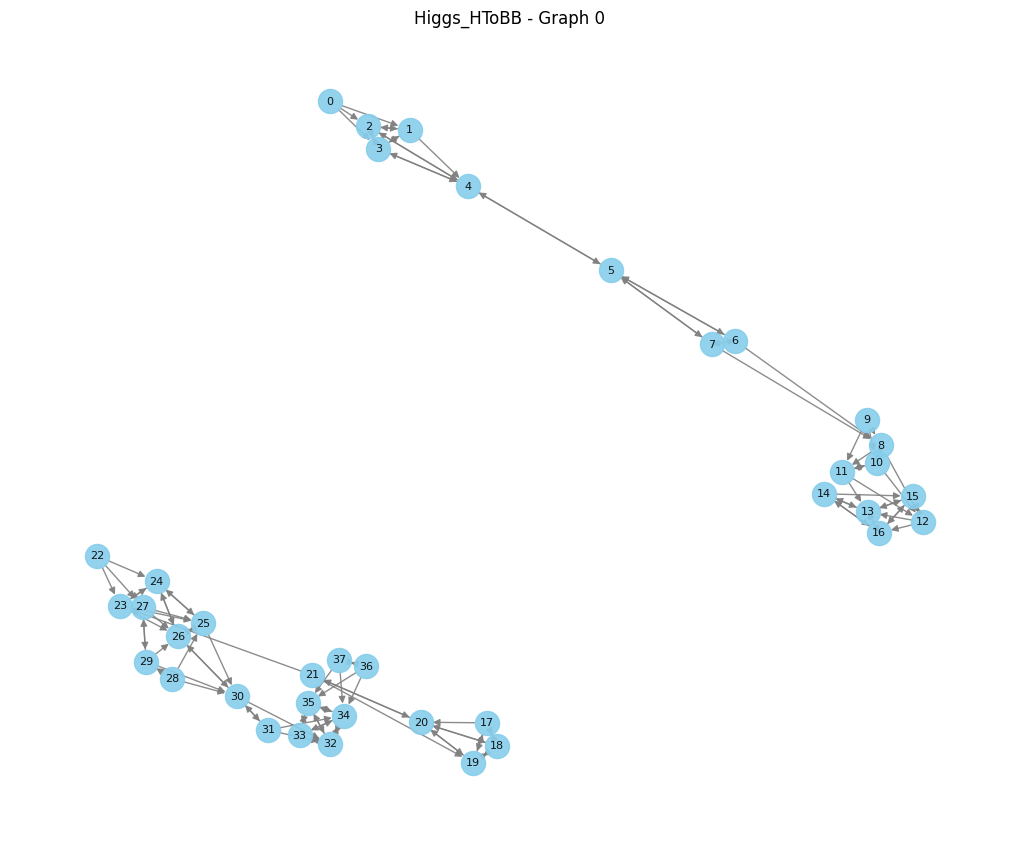

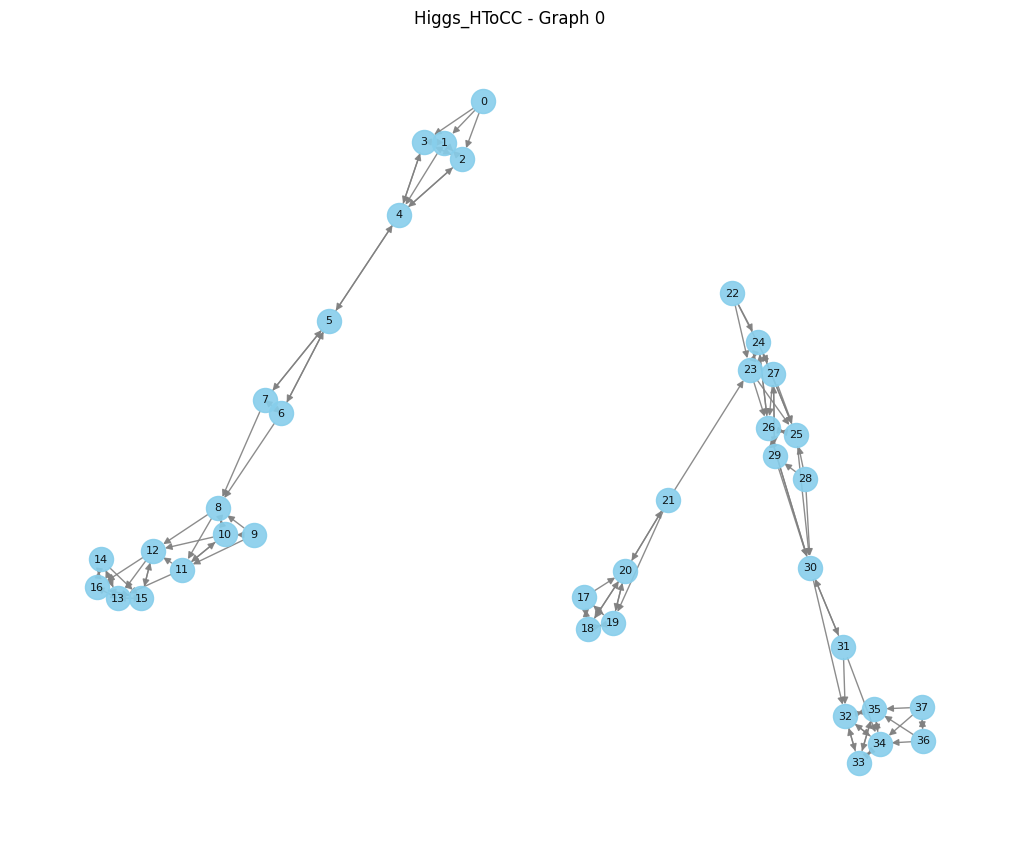

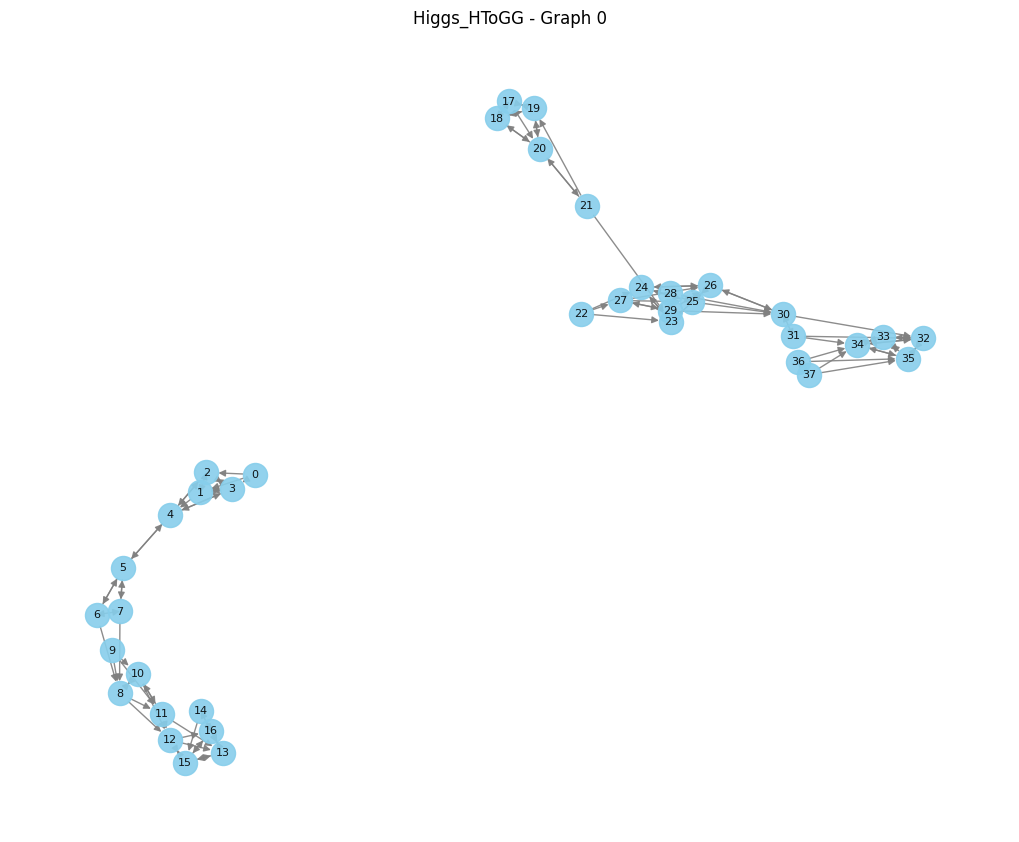

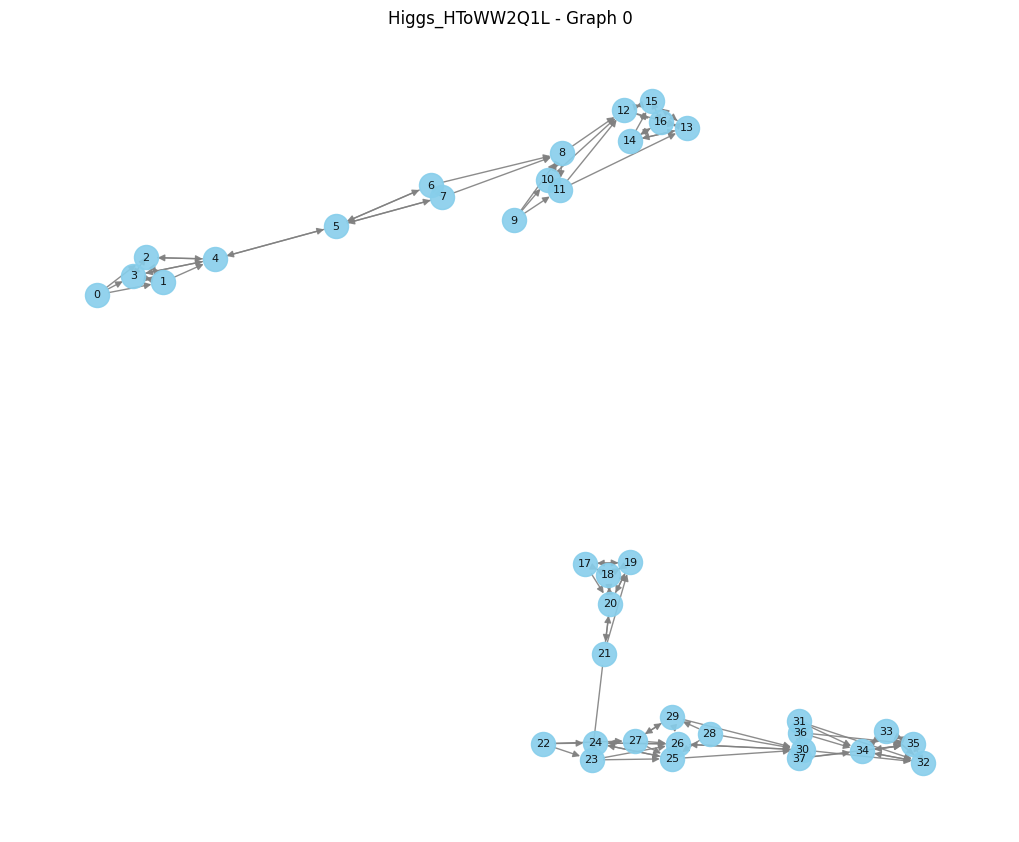

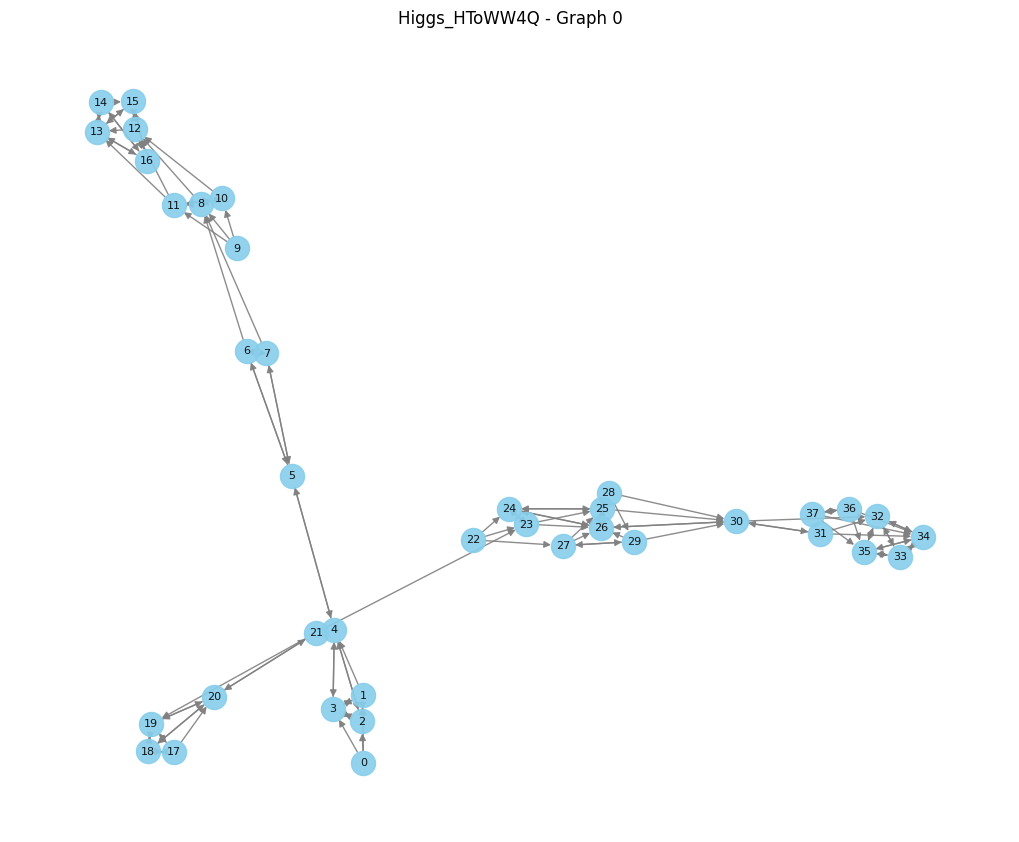

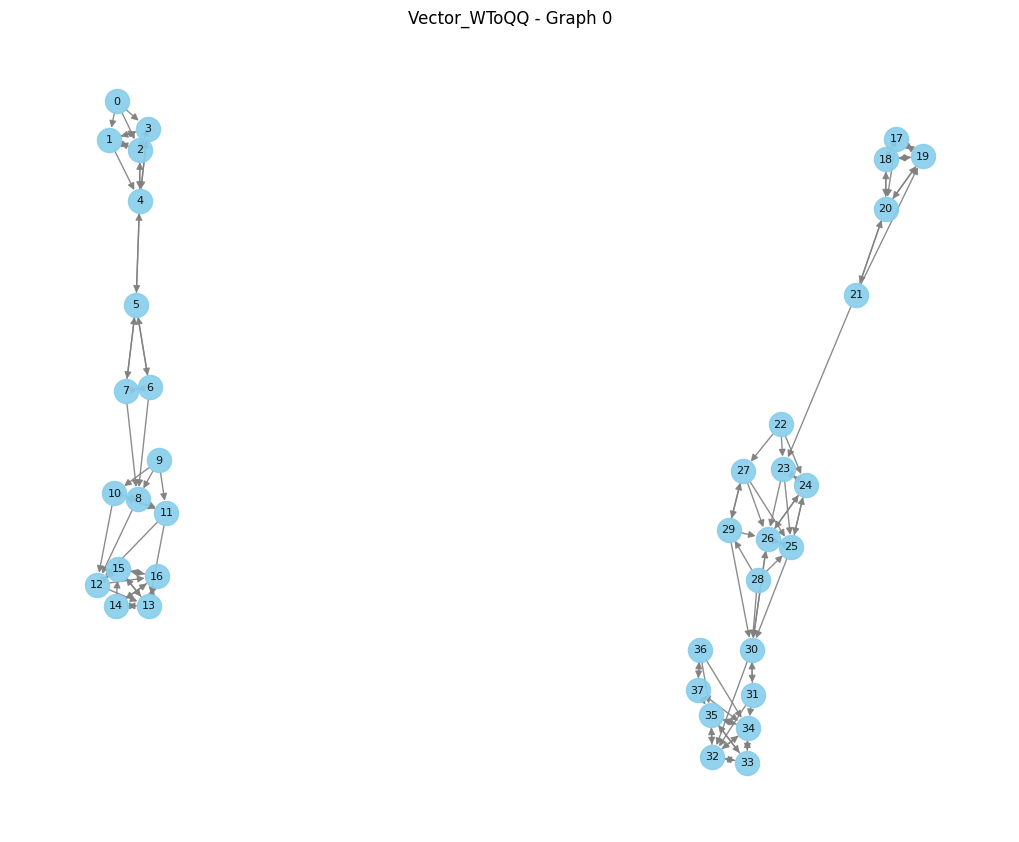

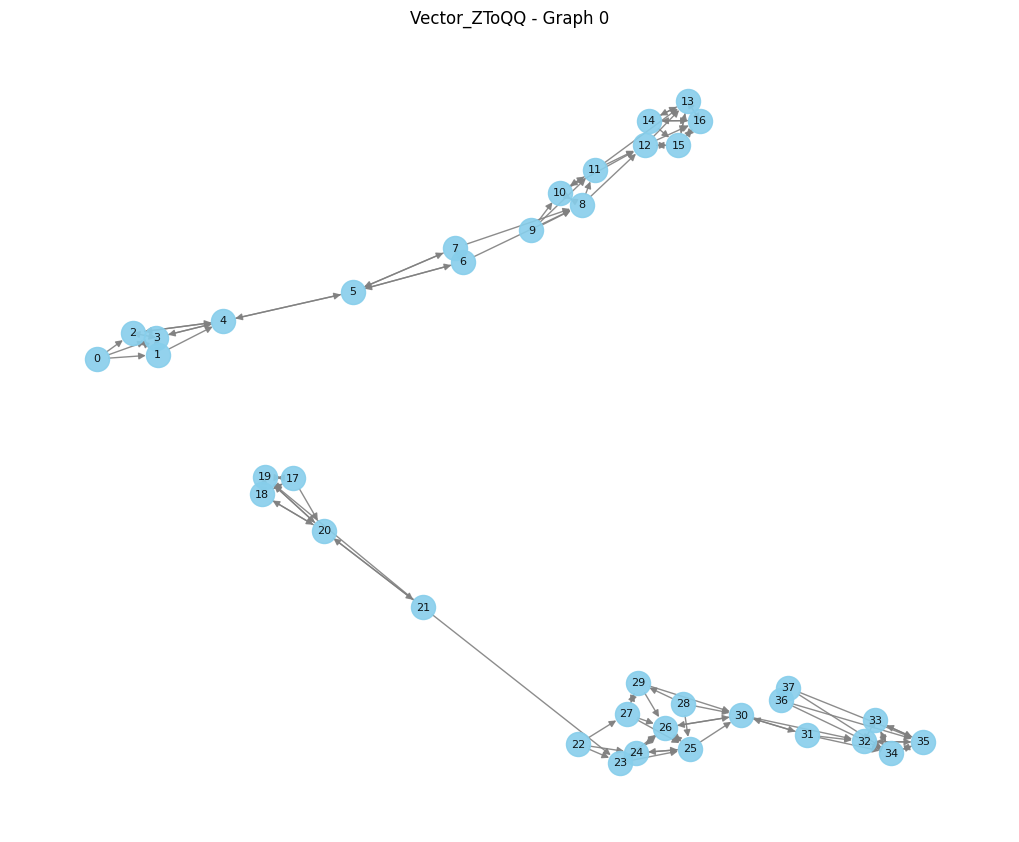

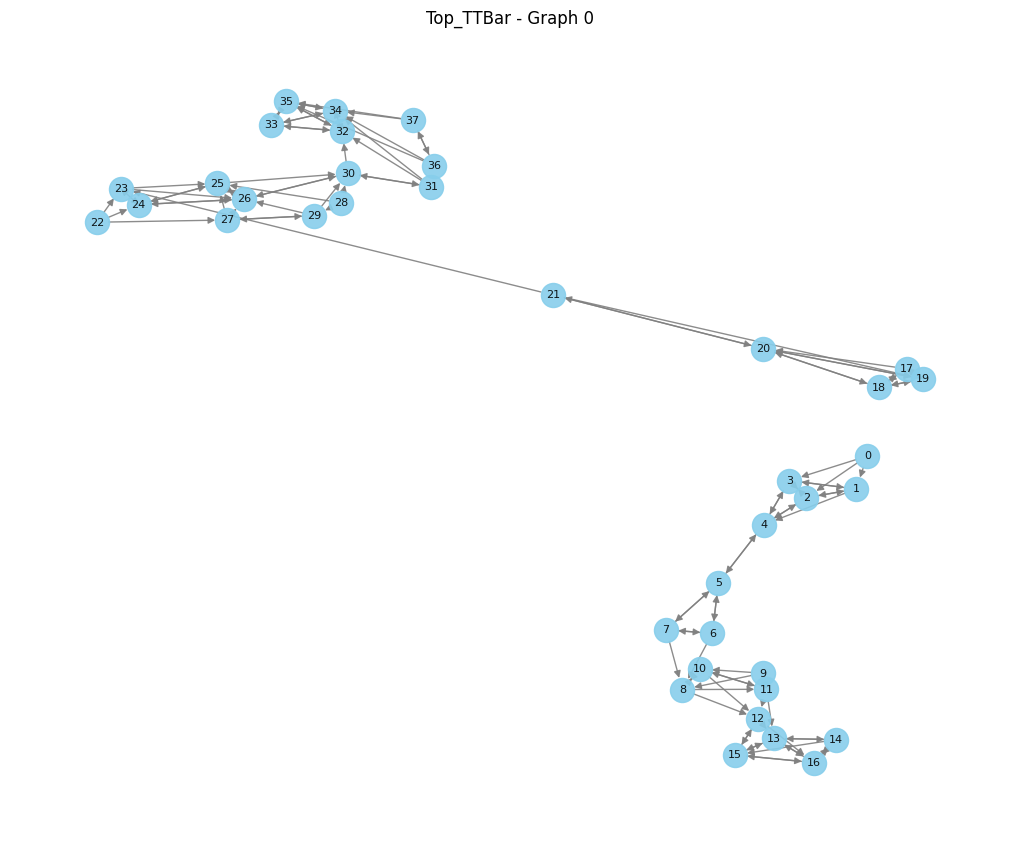

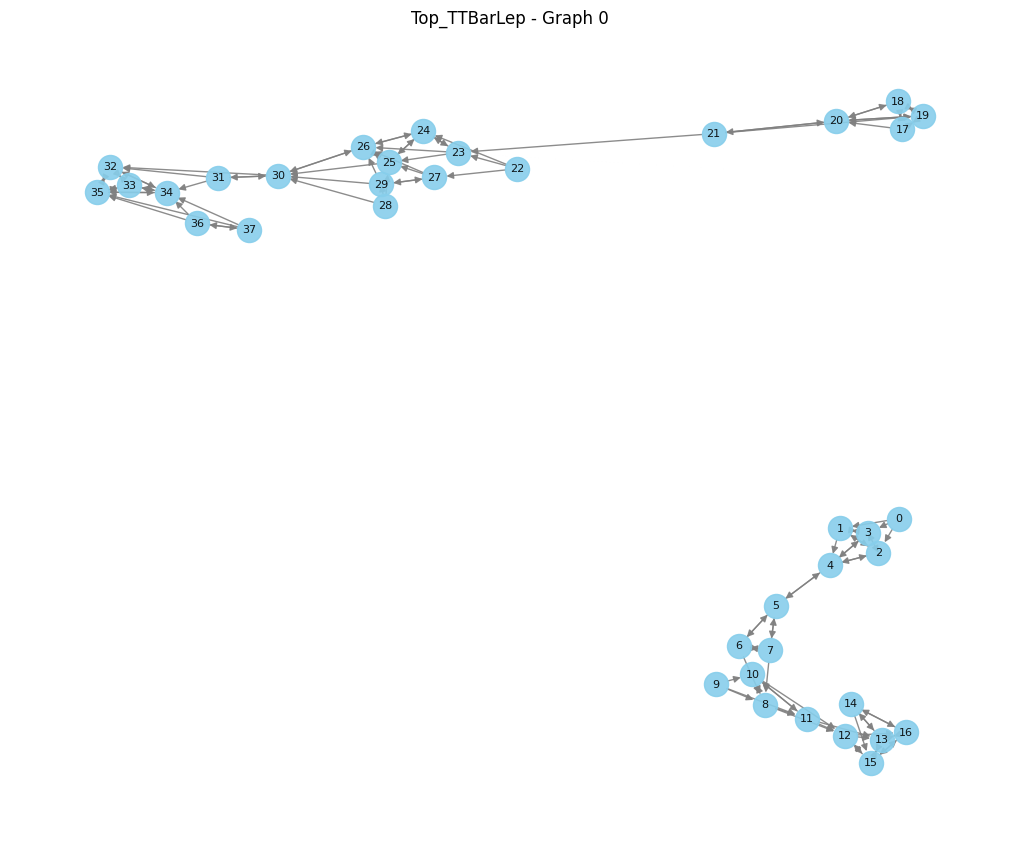

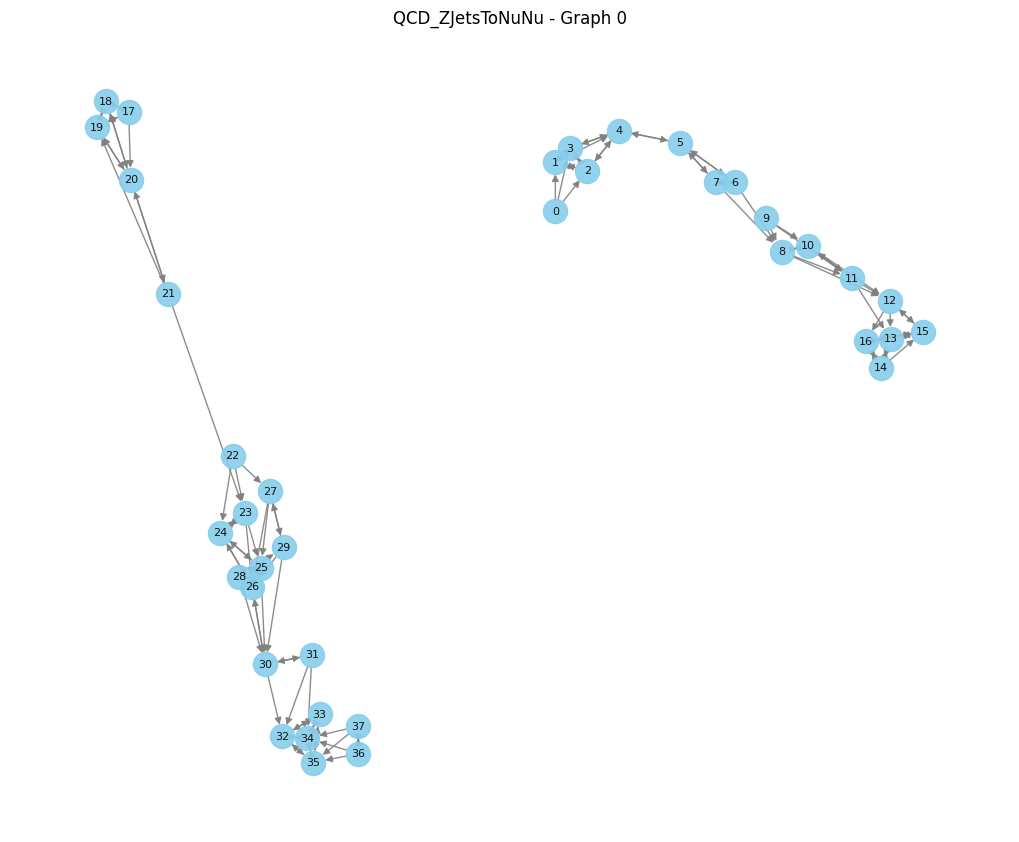

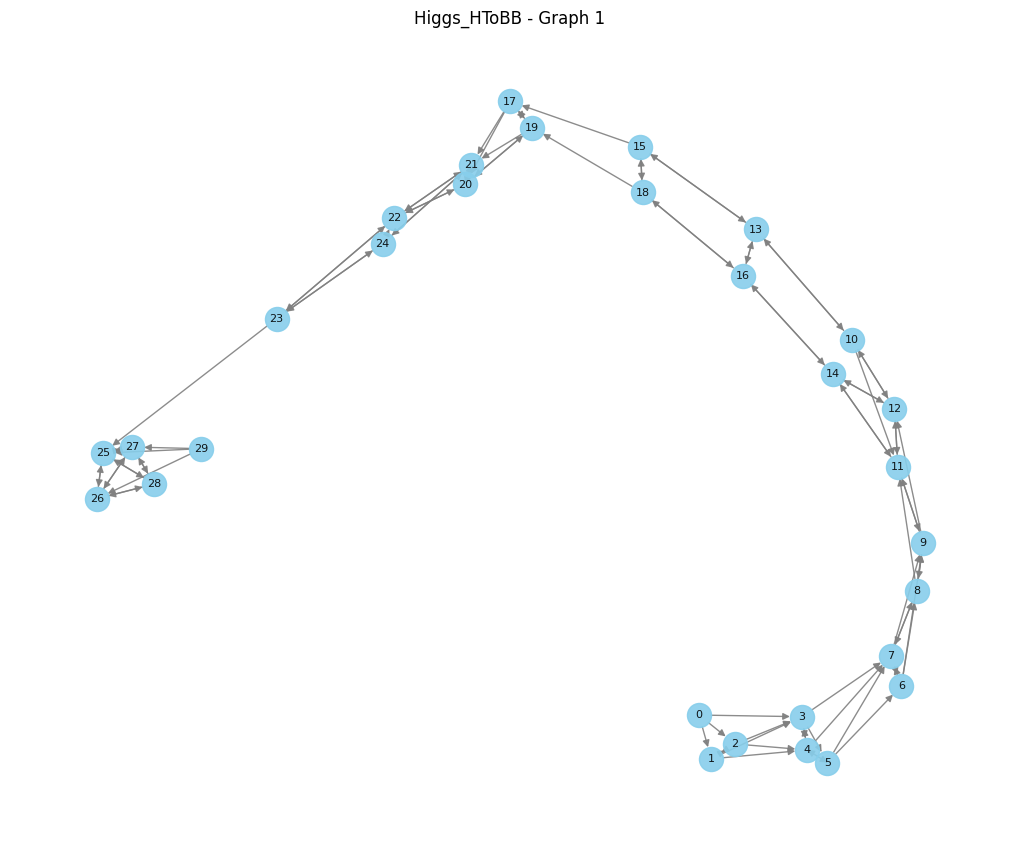

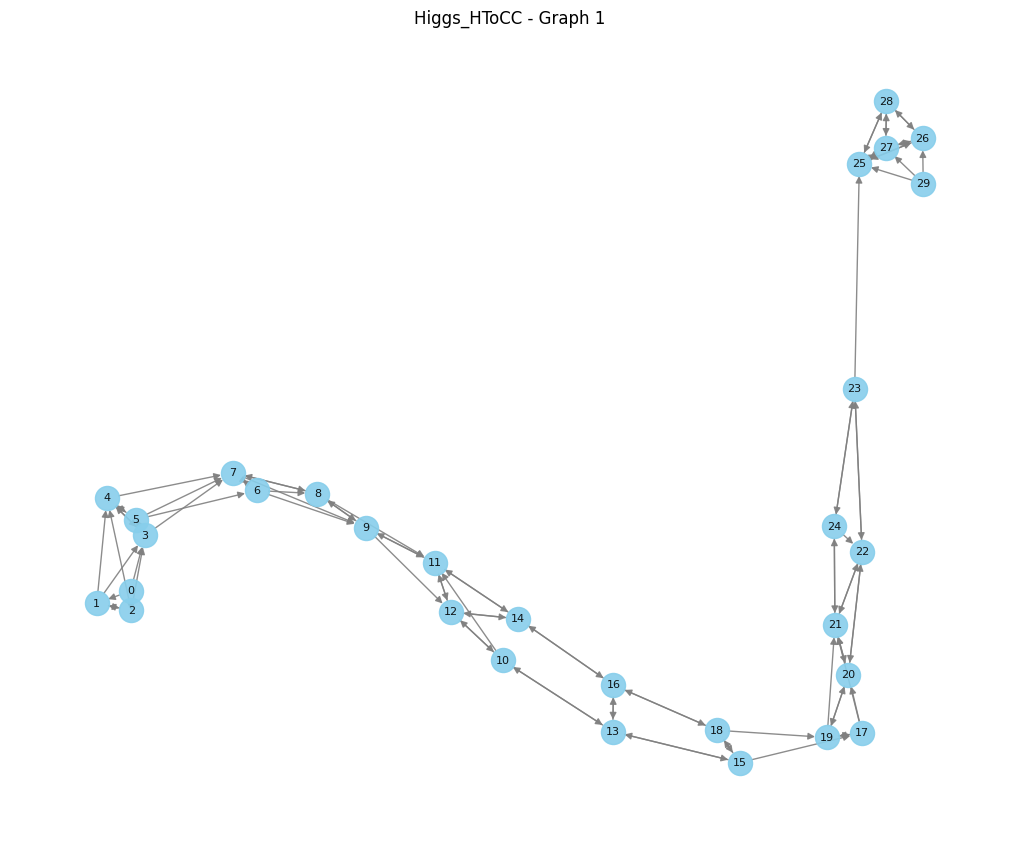

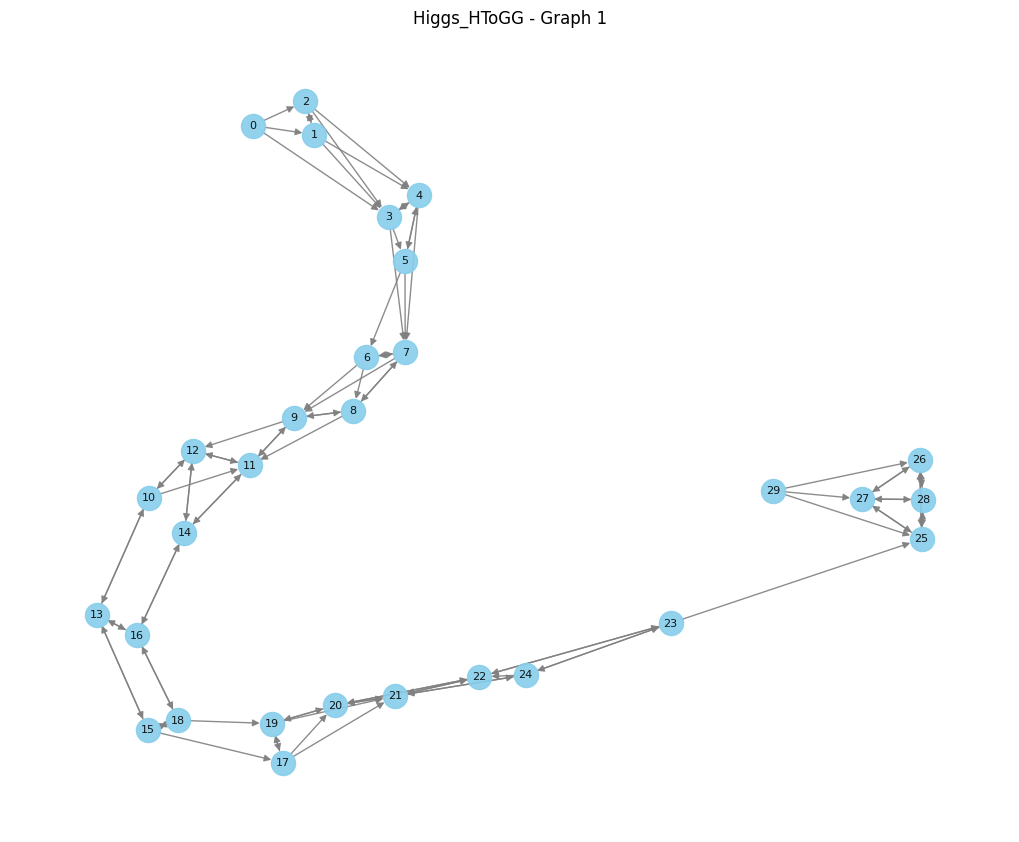

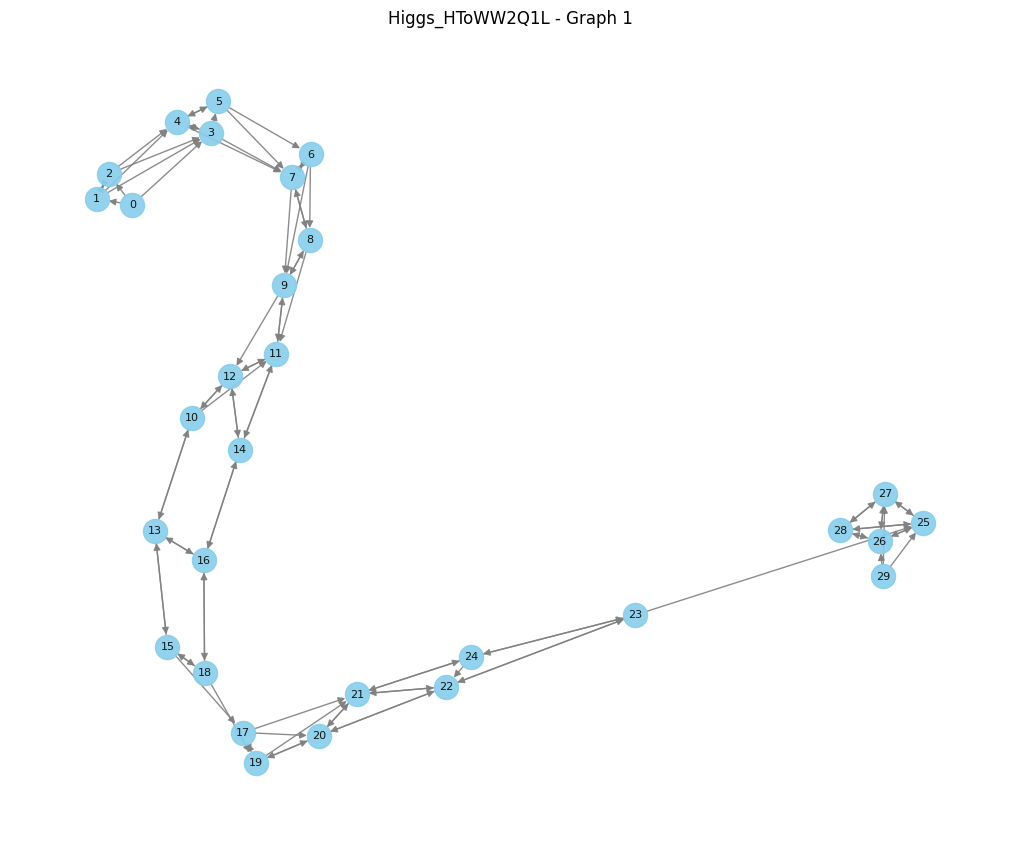

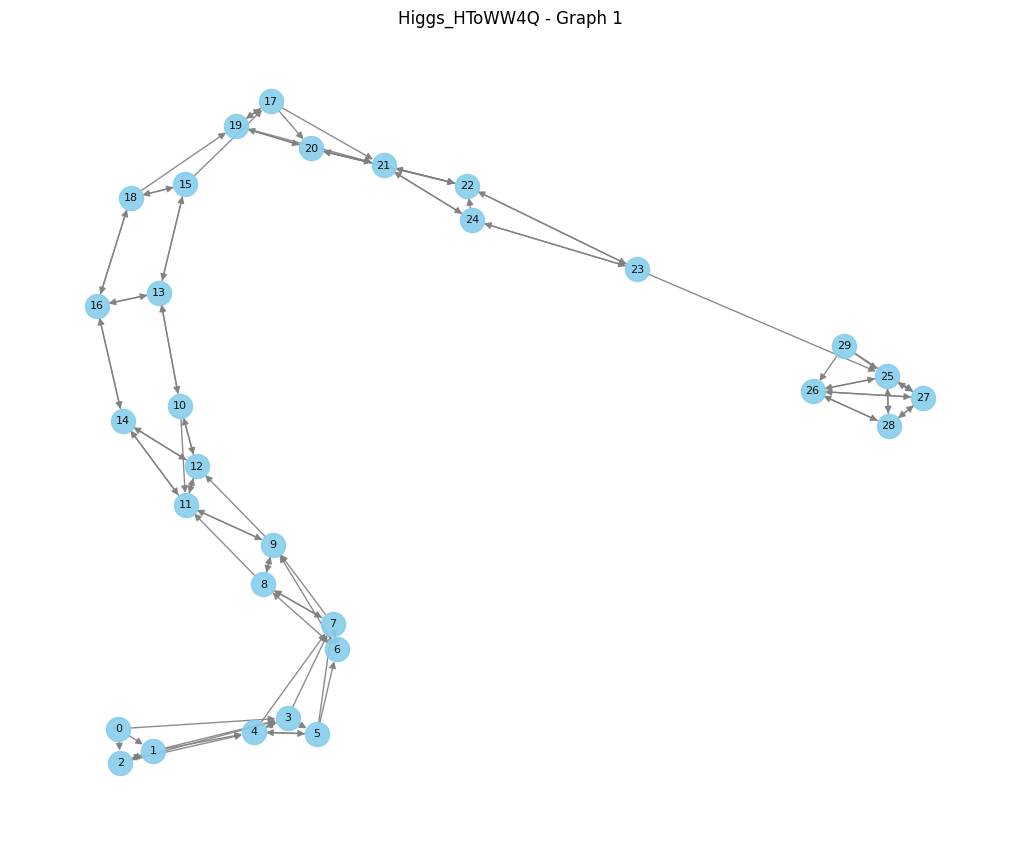

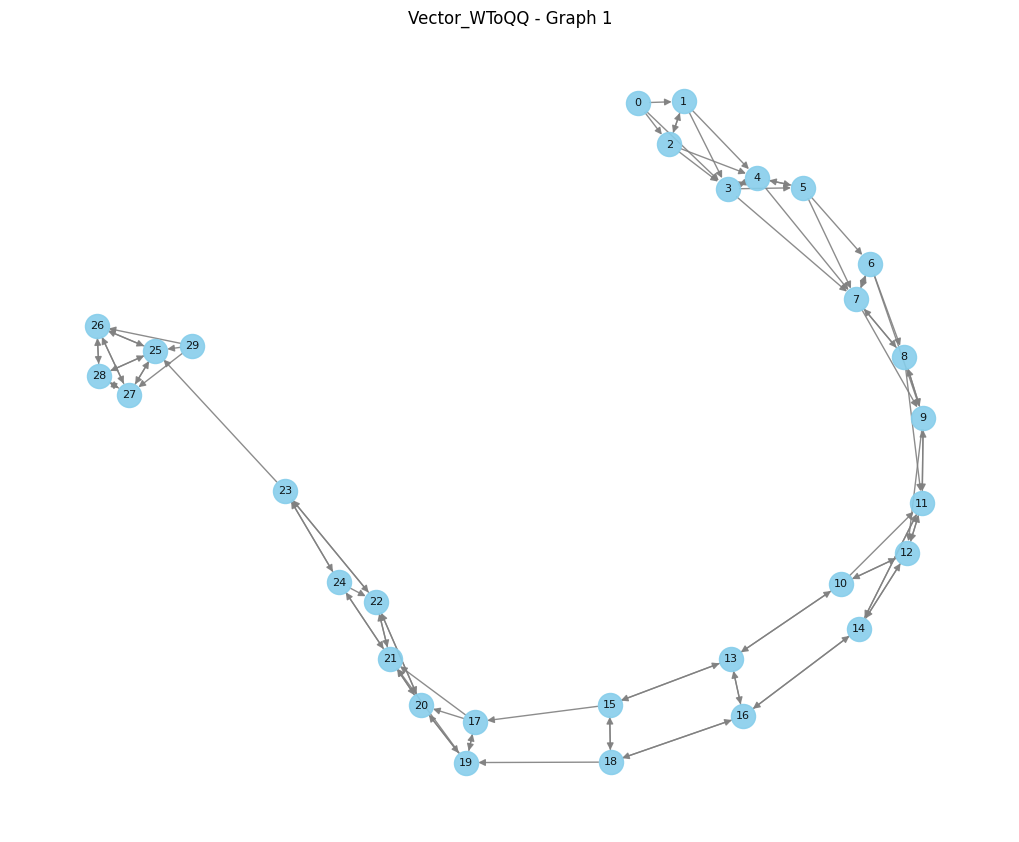

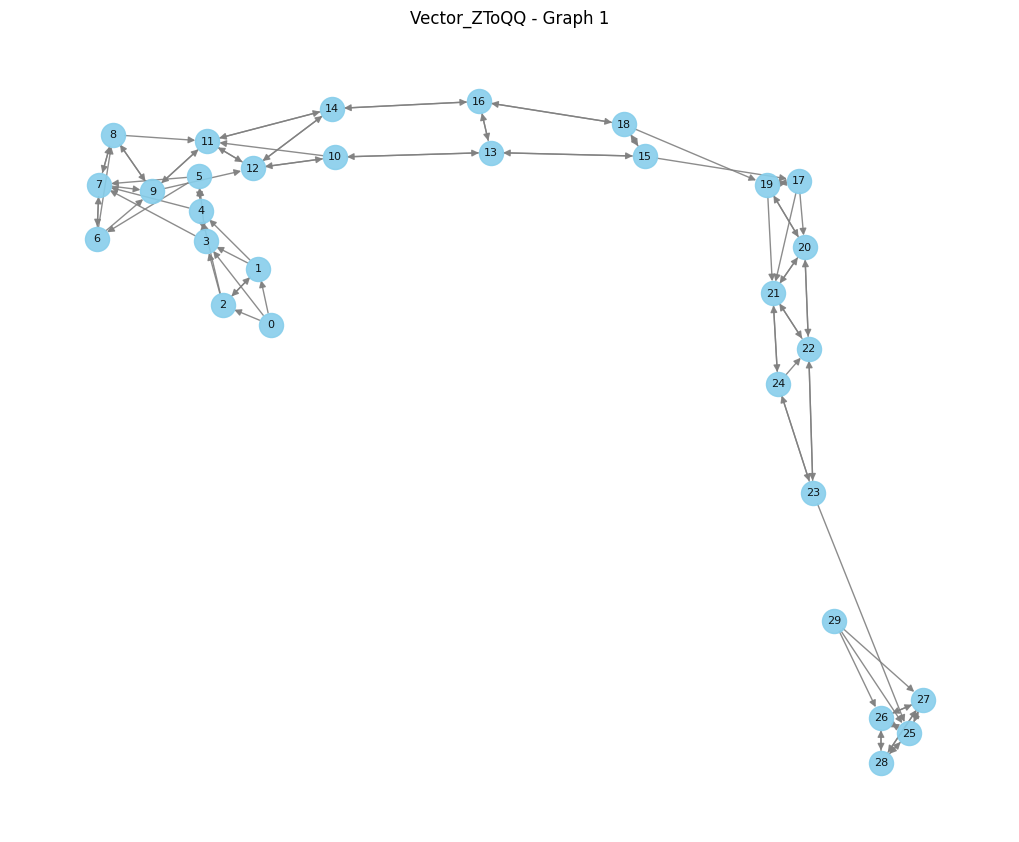

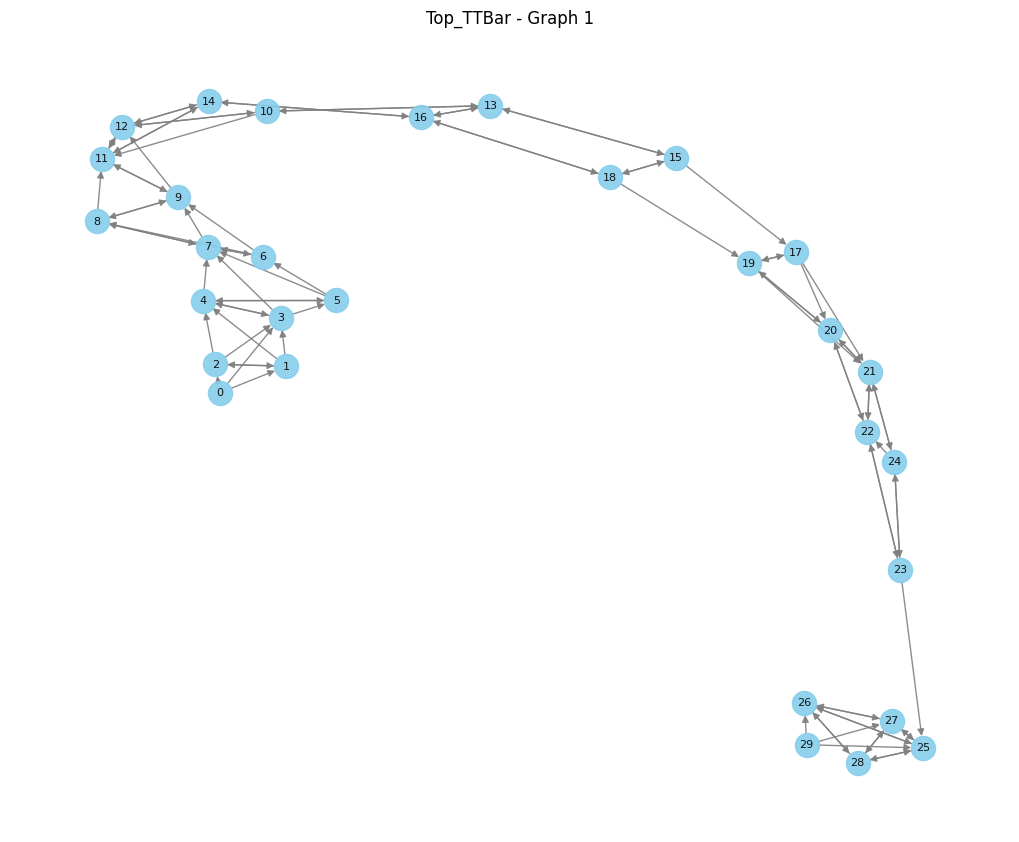

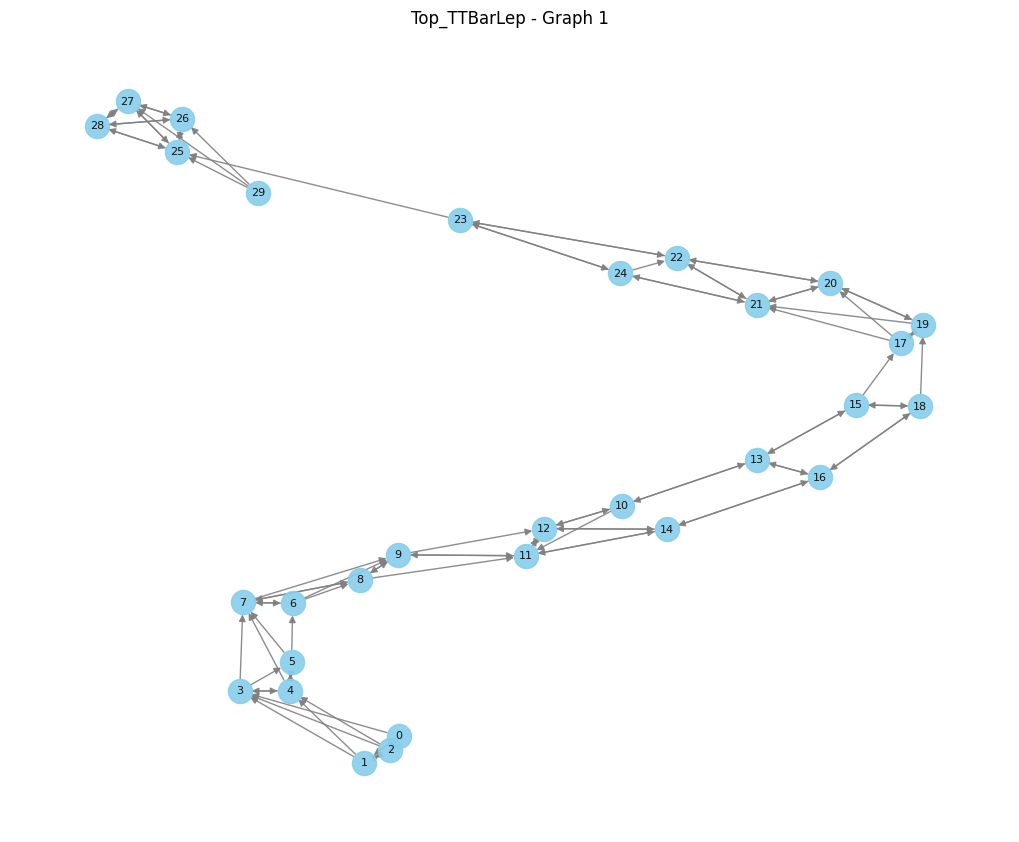

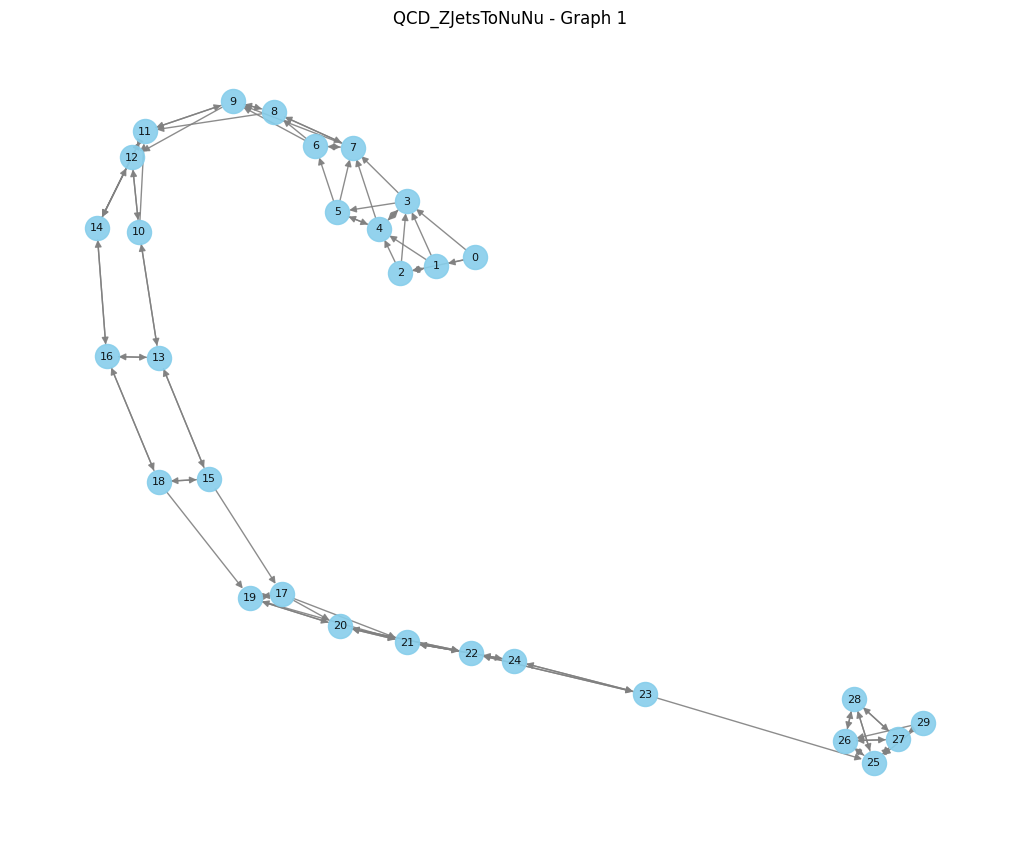

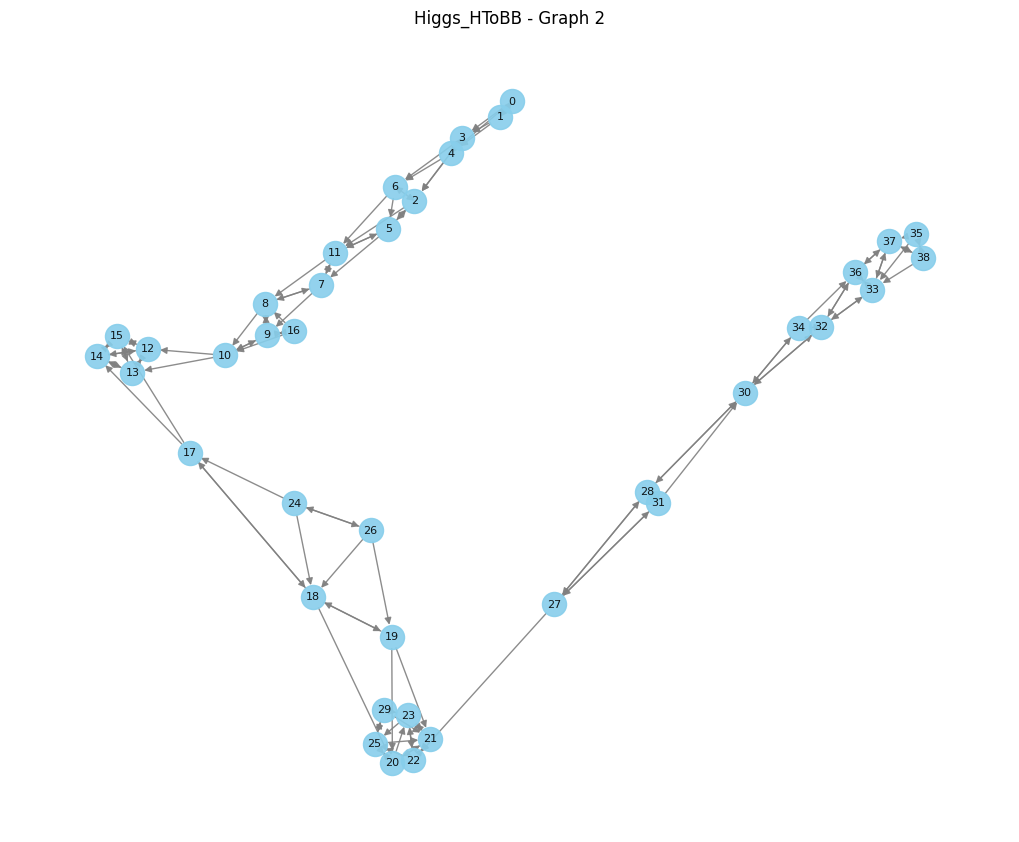

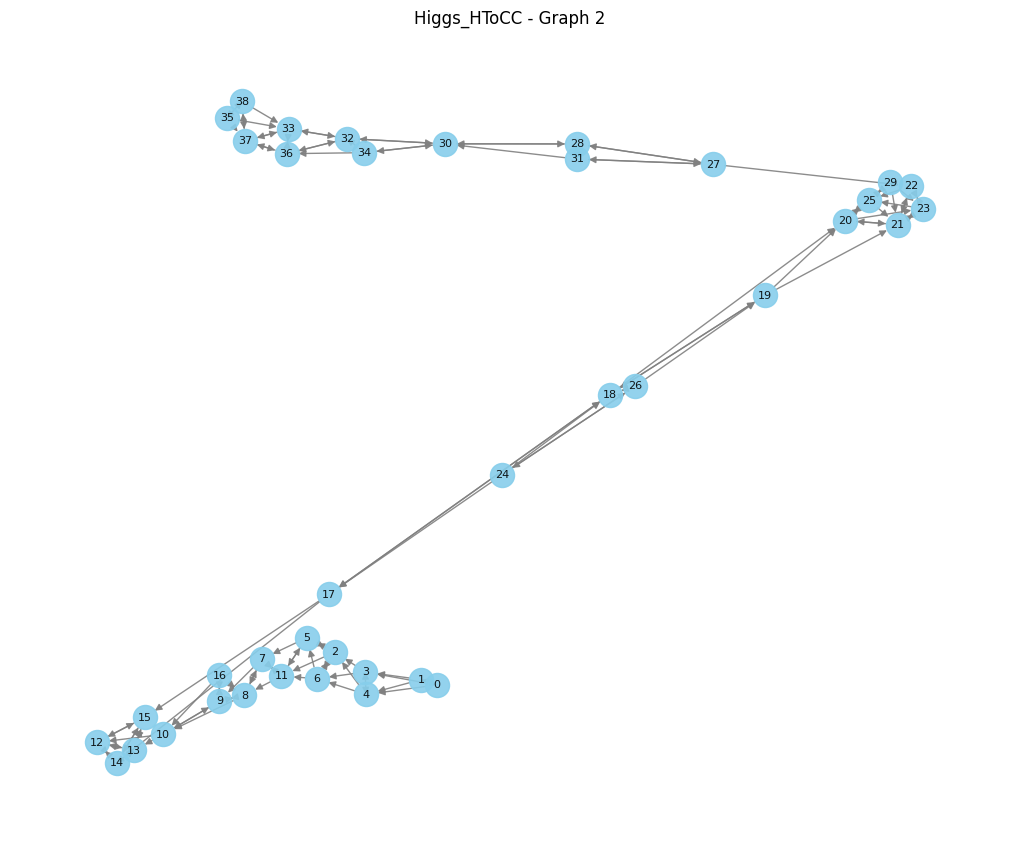

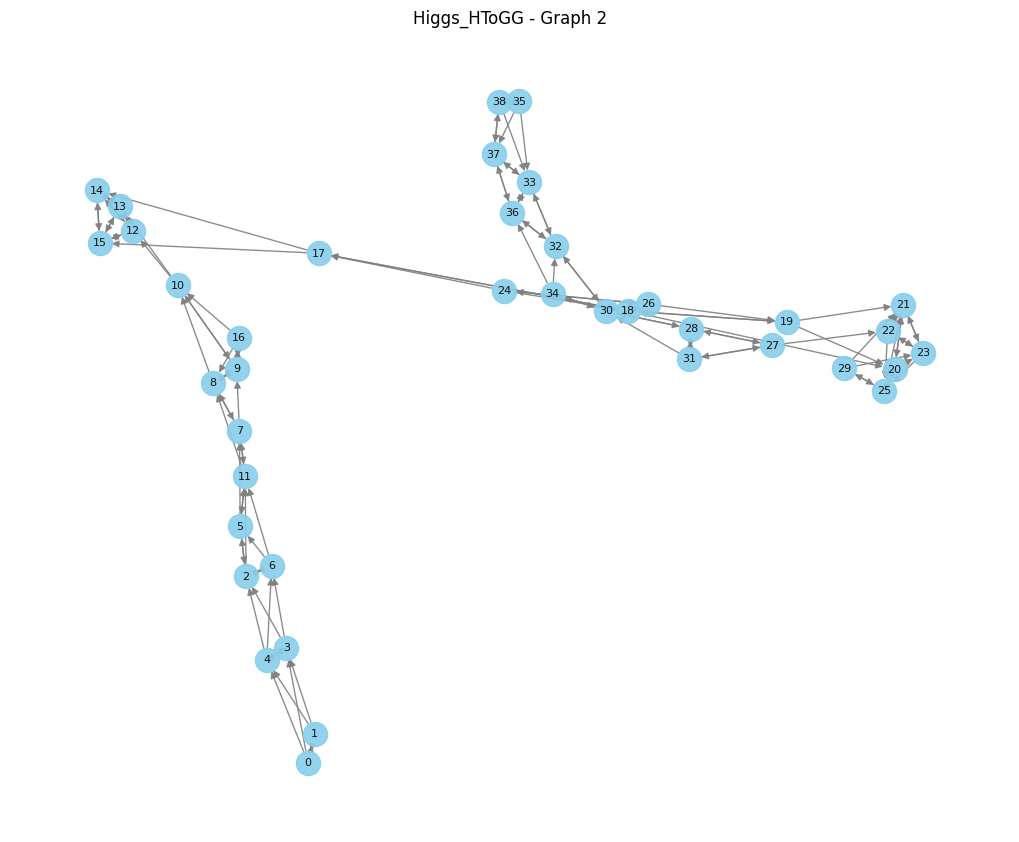

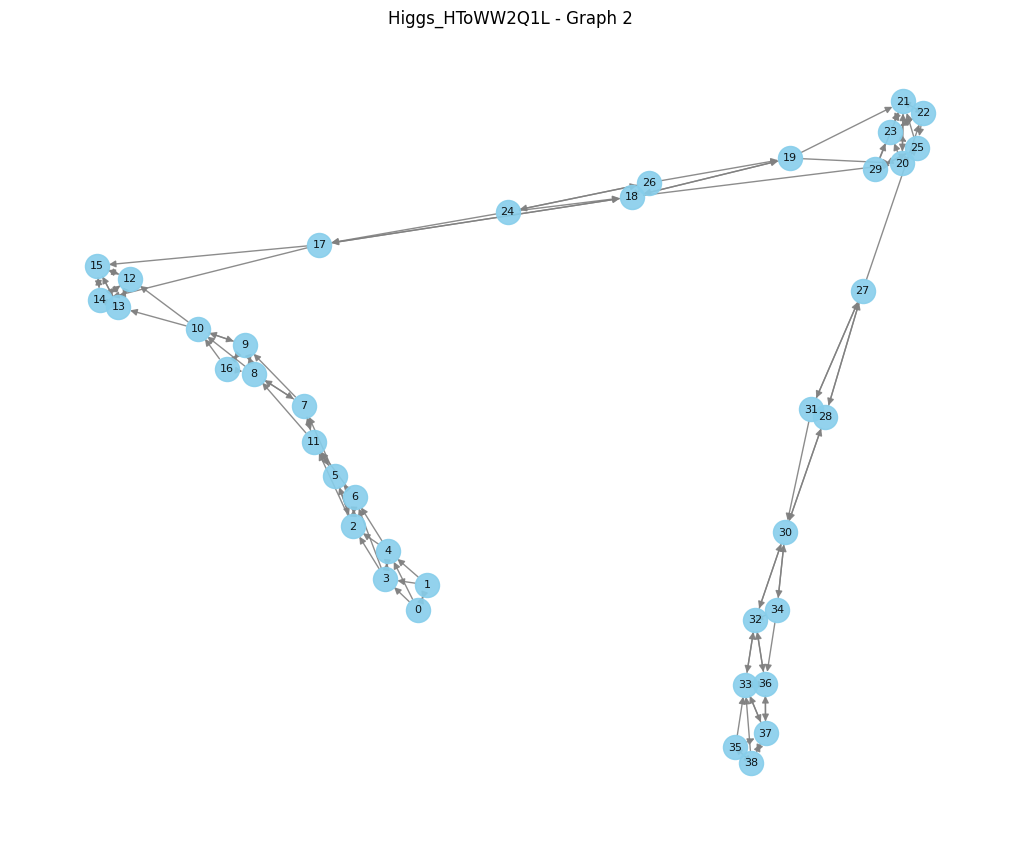

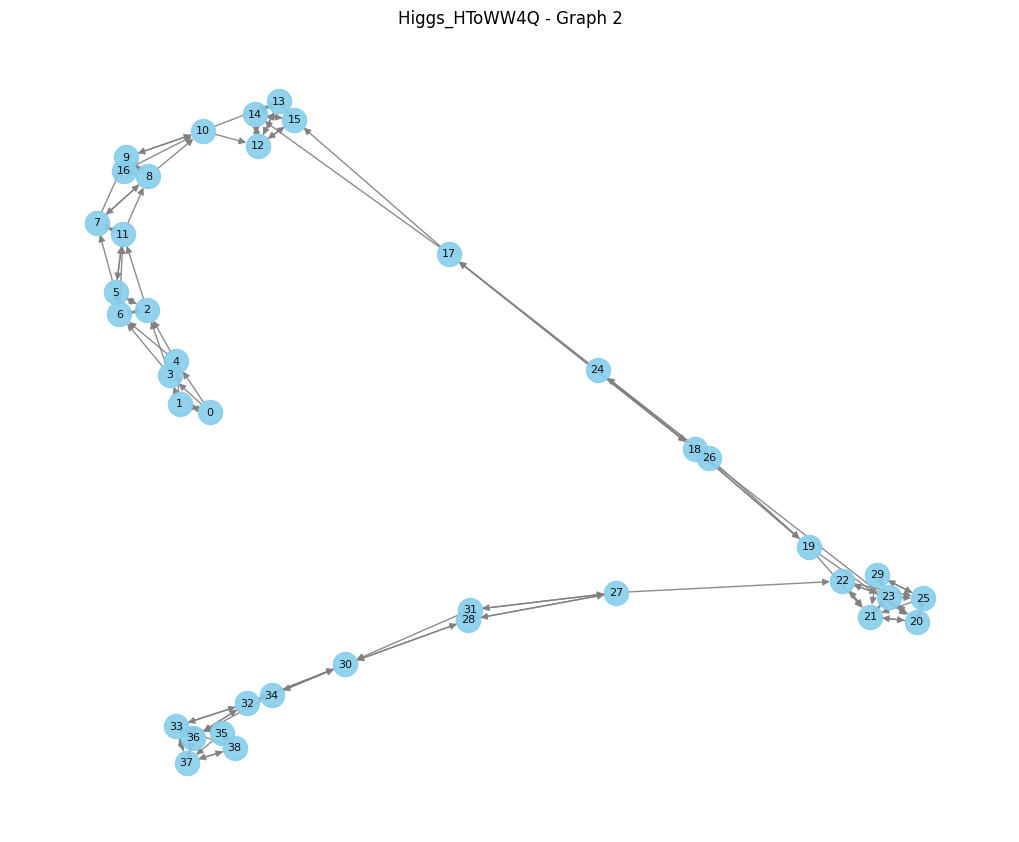

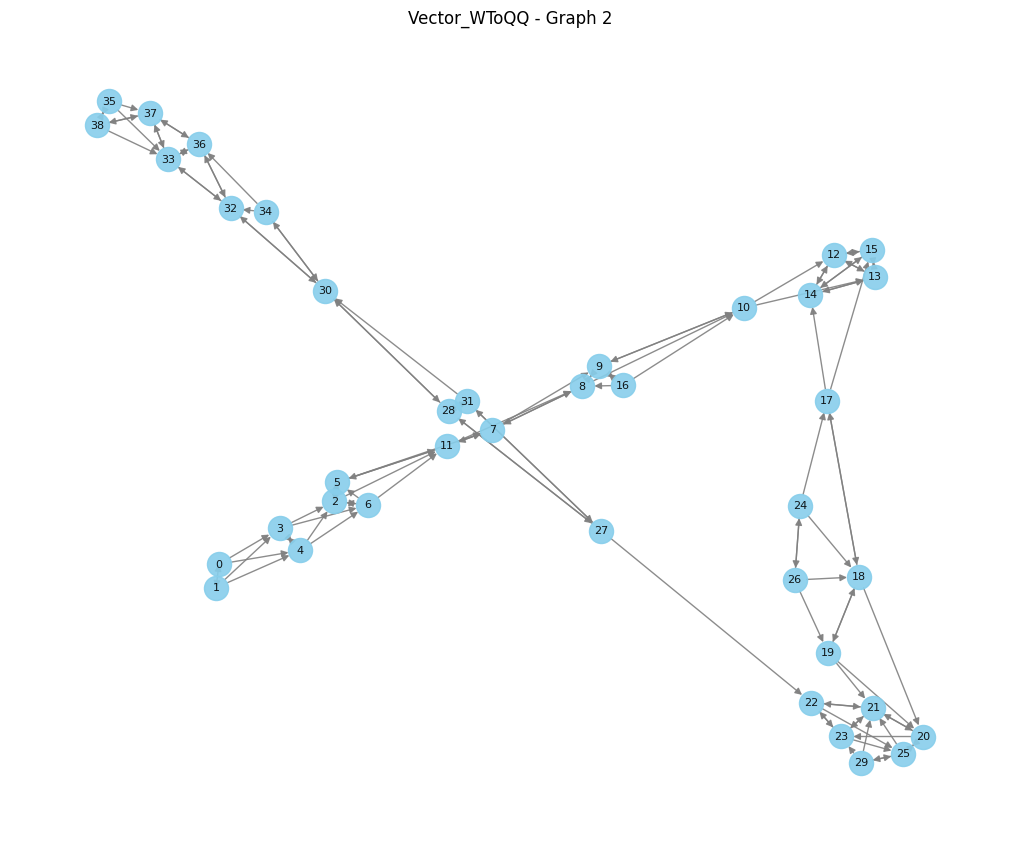

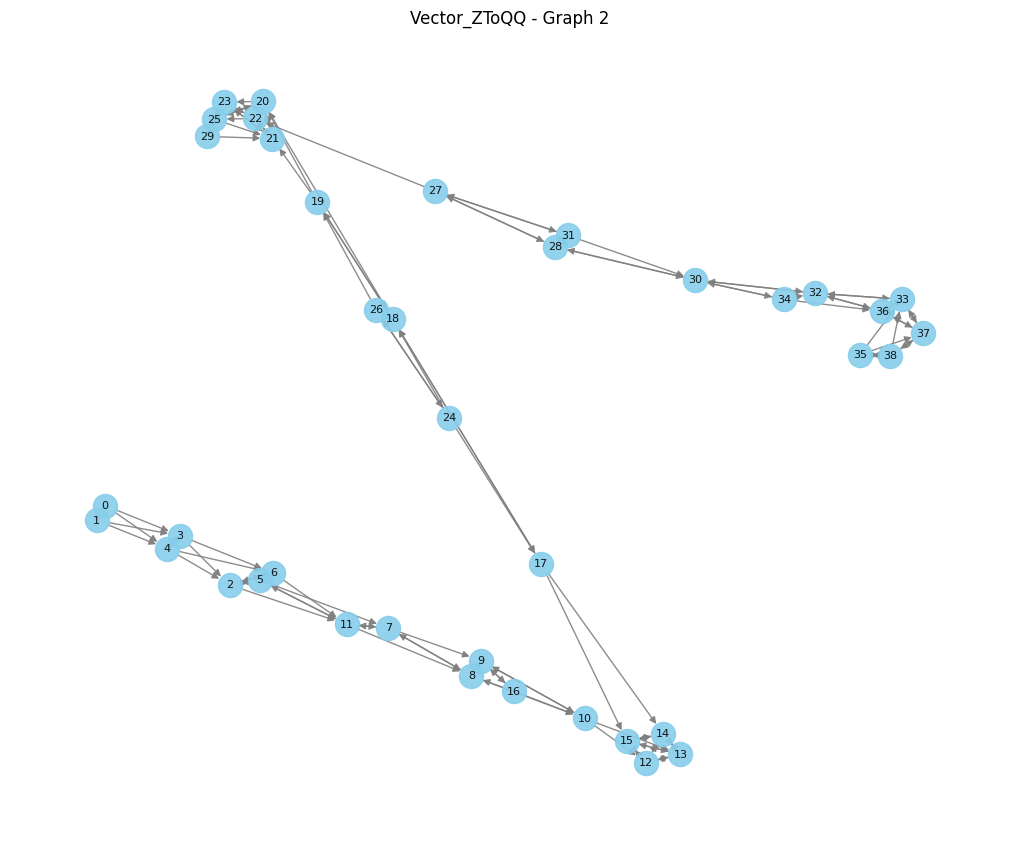

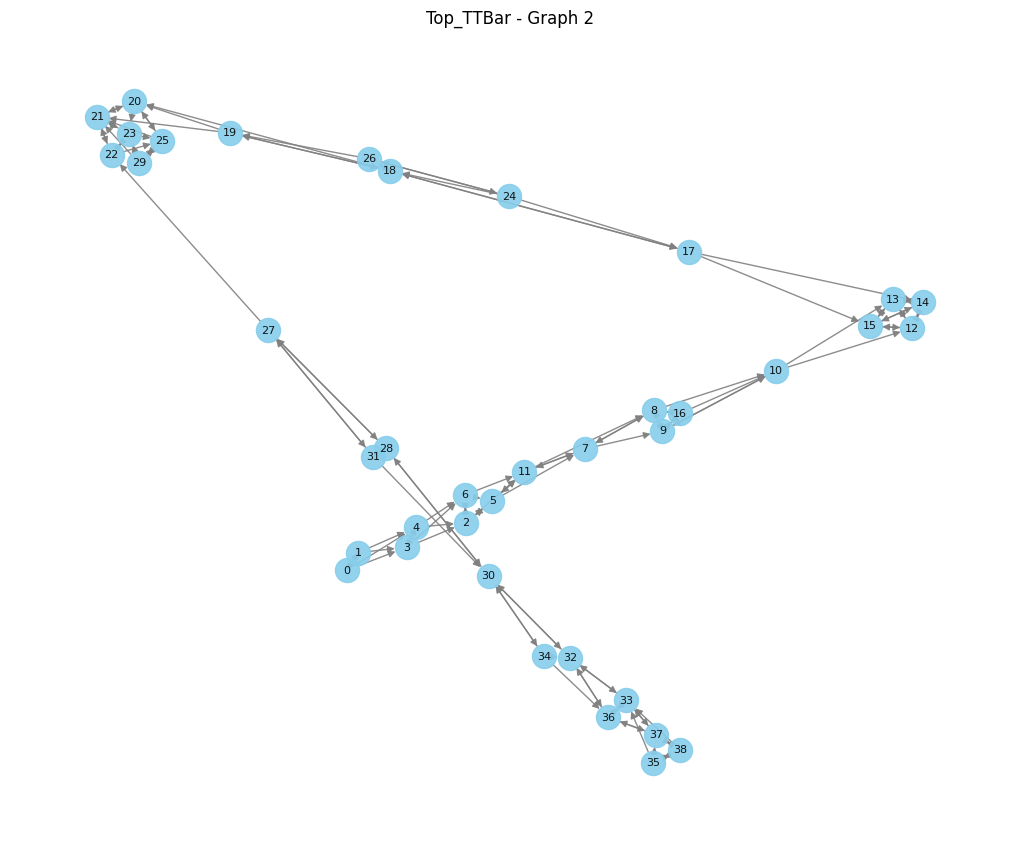

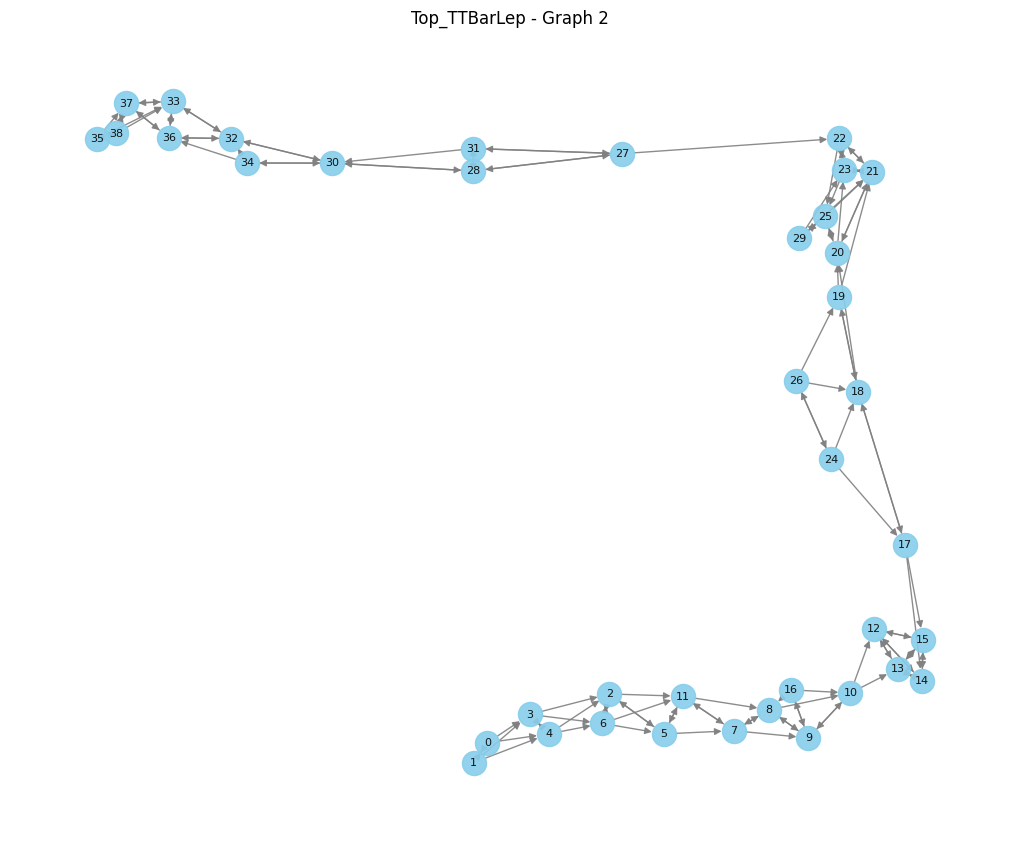

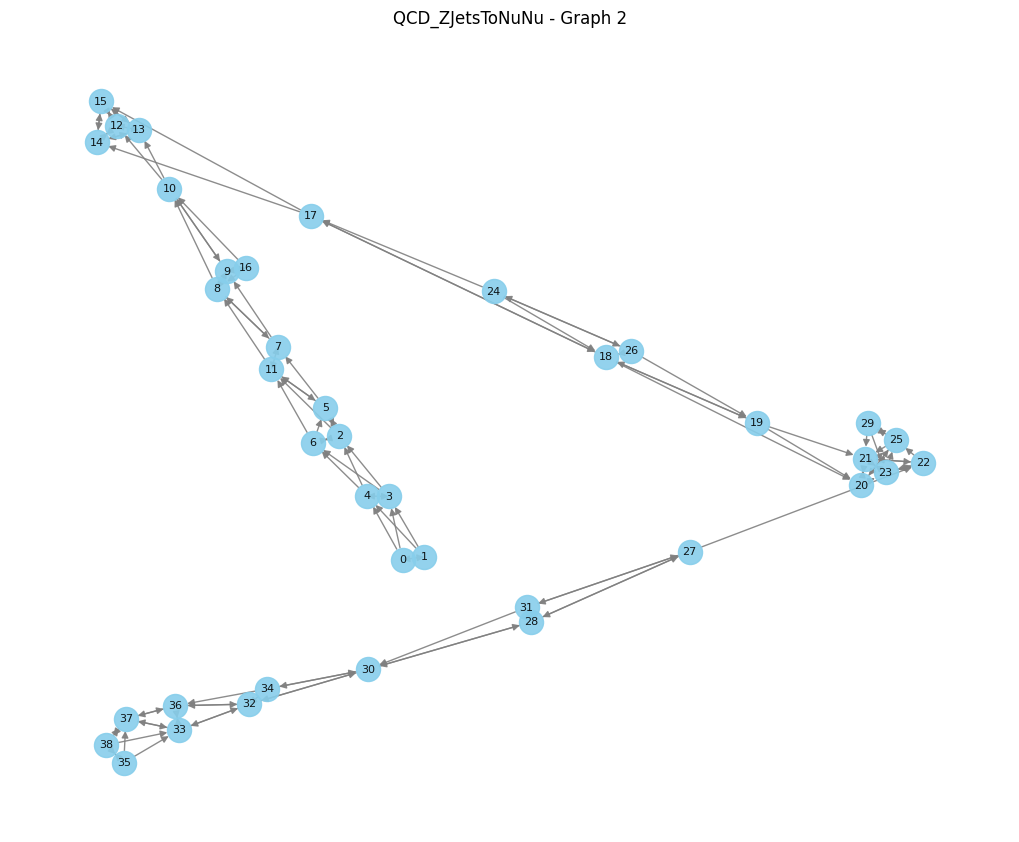

In [20]:
# Visualize the first 3 graphs sequentially for all jet types
indices = [0, 1, 2]
for idx in indices:
    for key in jet_types.keys():
        load_and_visualize_graph(f'./data/Multi Level Jet Tagging/Emitter-{key}.pkl', key, idx)


In [25]:
# Function to load only the first 3 graphs correctly
def load_first_n_graphs(file_path, n=3):
    """Loads only the first `n` graphs from a pickle file, assuming it's a list of graphs."""
    try:
        with open(file_path, 'rb') as f:
            graphs = pickle.load(f)  # Load the list of graphs
        
        if not isinstance(graphs, list):  # Ensure the loaded object is a list
            print(f"Unexpected format in {file_path}. Expected a list of graphs.")
            return []
        
        return [graphs[i].to_networkx() for i in range(min(n, len(graphs)))]  # Convert first `n` graphs
    except Exception as e:
        print(f"Failed to load {file_path}: {e}")
        return []

# Store graphs in a dictionary
graphs_dict = {key: load_first_n_graphs(f'./data/Multi Level Jet Tagging/Emitter-{key}.pkl', n=3) for key in jet_types.keys()}

# Function to compare graphs using isomorphism
def are_graphs_isomorphic(G1, G2):
    if G1 is None or G2 is None:
        return False
    matcher = GraphMatcher(G1, G2)
    return matcher.is_isomorphic()

# Compare graphs and store results
for idx in indices:
    similarity_matrix = pd.DataFrame(index=jet_types.keys(), columns=jet_types.keys(), dtype=bool)
    
    jet_keys = list(jet_types.keys())
    for i, key1 in enumerate(jet_keys):
        for j, key2 in enumerate(jet_keys):
            if i <= j:  # Avoid redundant comparisons
                graph1 = graphs_dict[key1][idx] if idx < len(graphs_dict[key1]) else None
                graph2 = graphs_dict[key2][idx] if idx < len(graphs_dict[key2]) else None
                similarity_matrix.loc[key1, key2] = are_graphs_isomorphic(graph1, graph2)
                similarity_matrix.loc[key2, key1] = similarity_matrix.loc[key1, key2]  # Symmetric matrix
    
    print(f"\n### Graph {idx} Similarity Matrix ###")
    print(similarity_matrix)


### Graph 0 Similarity Matrix ###
                 Higgs_HToBB  Higgs_HToCC  Higgs_HToGG  Higgs_HToWW2Q1L  \
Higgs_HToBB             True         True         True             True   
Higgs_HToCC             True         True         True             True   
Higgs_HToGG             True         True         True             True   
Higgs_HToWW2Q1L         True         True         True             True   
Higgs_HToWW4Q           True         True         True             True   
Vector_WToQQ            True         True         True             True   
Vector_ZToQQ            True         True         True             True   
Top_TTBar               True         True         True             True   
Top_TTBarLep            True         True         True             True   
QCD_ZJetsToNuNu         True         True         True             True   

                 Higgs_HToWW4Q  Vector_WToQQ  Vector_ZToQQ  Top_TTBar  \
Higgs_HToBB               True          True          True       T

In [26]:
# Function to load the first graph only
def load_first_graph(file_path):
    """Loads only the first graph from a pickle file, assuming it's a list of graphs."""
    try:
        with open(file_path, 'rb') as f:
            graphs = pickle.load(f)  # Load the list of graphs
        
        if not isinstance(graphs, list) or len(graphs) == 0:  
            print(f"No valid graphs in {file_path}.")
            return None
        
        return graphs[0].to_networkx()  # Convert the first graph to a NetworkX graph
    except Exception as e:
        print(f"Failed to load {file_path}: {e}")
        return None

# Store first graphs in a dictionary
first_graphs = {key: load_first_graph(f'./data/Multi Level Jet Tagging/Emitter-{key}.pkl') for key in jet_types.keys()}

# Function to compare graphs using isomorphism
def are_graphs_isomorphic(G1, G2):
    if G1 is None or G2 is None:
        return False
    matcher = GraphMatcher(G1, G2)
    return matcher.is_isomorphic()

# Compare the first graph of each jet type
similarity_matrix = pd.DataFrame(index=jet_types.keys(), columns=jet_types.keys(), dtype=bool)

jet_keys = list(jet_types.keys())
for i, key1 in enumerate(jet_keys):
    for j, key2 in enumerate(jet_keys):
        if i <= j:  # Avoid redundant comparisons
            similarity_matrix.loc[key1, key2] = are_graphs_isomorphic(first_graphs[key1], first_graphs[key2])
            similarity_matrix.loc[key2, key1] = similarity_matrix.loc[key1, key2]  # Symmetric matrix

# Display the similarity matrix
print("\n### First Graph Similarity Matrix ###")
print(similarity_matrix)

/media/drive1/jettag/env_jet/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))



### First Graph Similarity Matrix ###
                 Higgs_HToBB  Higgs_HToCC  Higgs_HToGG  Higgs_HToWW2Q1L  \
Higgs_HToBB             True         True         True             True   
Higgs_HToCC             True         True         True             True   
Higgs_HToGG             True         True         True             True   
Higgs_HToWW2Q1L         True         True         True             True   
Higgs_HToWW4Q           True         True         True             True   
Vector_WToQQ            True         True         True             True   
Vector_ZToQQ            True         True         True             True   
Top_TTBar               True         True         True             True   
Top_TTBarLep            True         True         True             True   
QCD_ZJetsToNuNu         True         True         True             True   

                 Higgs_HToWW4Q  Vector_WToQQ  Vector_ZToQQ  Top_TTBar  \
Higgs_HToBB               True          True          True    

In [9]:
def count_graphs(file_path):
    try:
        with open(file_path, 'rb') as f:
            graphs = pickle.load(f)
        print(f"File '{file_path}' loaded successfully! Total number of graphs: {len(graphs)}")
    except Exception as e:
        print(f"Failed to load the file '{file_path}': {e}")

In [10]:
# Loop through all detected files and process them
for file in files:
    count_graphs(file)

File './data/Multi Level Jet Tagging/Emitter-Higgs_HToBB.pkl' loaded successfully! Total number of graphs: 99997
File './data/Multi Level Jet Tagging/Emitter-Higgs_HToCC.pkl' loaded successfully! Total number of graphs: 99997


# First and Last 5 Graphs

In [ ]:
# Part 2: Load and visualize graphs independently
def load_graphs(file_path):
    try:
        with open(file_path, 'rb') as f:
            graphs = pickle.load(f)
        return graphs
    except Exception as e:
        print(f"Failed to load the file: {e}")
        return None

def visualize_graph_with_labels(graphs, indices):
    if graphs is None:
        print("No graphs to visualize.")
        return
    
    for idx in indices:
        if idx >= len(graphs) or idx < 0:
            print(f"Index {idx} is out of range.")
            continue
        
        g = graphs[idx]
        nx_graph = g.to_networkx()

        # Layout for better graph organization
        pos = nx.spring_layout(nx_graph)

        plt.figure(figsize=(10, 8))
        nx.draw(
            nx_graph, pos,
            with_labels=True,
            labels={node: node for node in nx_graph.nodes()},
            node_size=300,
            node_color="skyblue",
            font_size=8,
            font_color="black",
            edge_color="gray",
            alpha=0.9
        )
        plt.title(f"Graph {idx}")
        plt.show()

# Load graphs and visualize them
graphs = load_graphs(file_path)
if graphs:
    first_5_indices = list(range(min(5, len(graphs))))
    last_5_indices = list(range(max(0, len(graphs) - 5), len(graphs)))
    
    visualize_graph_with_labels(graphs, first_5_indices)
    visualize_graph_with_labels(graphs, last_5_indices)


# Maximum Number of Particles in a Single Jet

In [ ]:
import uproot
import awkward as ak
import numpy as np

def max_particles_in_jet(root_file_path):
    # Open the ROOT file and extract the tree
    file = uproot.open(root_file_path)
    tree = file["tree"]

    # Extract all particle-related branches
    awk_array = tree.arrays(["part_px"], how=dict) 

    # Count number of particles per jet
    num_particles_per_jet = ak.num(awk_array["part_px"])

    # Find the maximum number of particles in a single jet
    max_particles = np.max(num_particles_per_jet)

    return max_particles

# Example usage
root_file_path = './data/JetClass/JetRoots/JetClass_example_100k.root'
max_particles = max_particles_in_jet(root_file_path)
print(f"Maximum number of particles in a jet: {max_particles}")


# Get the top 10 graphs with the highest number of nodes

In [ ]:
import pickle
import networkx as nx
import matplotlib.pyplot as plt

def get_top_10_graphs(graphs):
    info_list = []
    for i, g in enumerate(graphs):
        num_nodes = g.num_nodes()
        info = {
            "Original Index": i,  # Preserve original index
            "Num Nodes": num_nodes
        }
        info_list.append(info)
    
    # Sort by number of nodes in descending order
    graph_info_sorted = sorted(info_list, key=lambda x: x["Num Nodes"], reverse=True)
    
    # Get the top 10 graphs
    top_10_graphs = graph_info_sorted[:10]
    return top_10_graphs

# Load the saved .pkl file
file_path = './data/Multi Level Jet Tagging/Emitter-Higgs.pkl'
try:
    with open(file_path, 'rb') as f:
        graphs = pickle.load(f)
    print(f"File loaded successfully! Total number of graphs: {len(graphs)}")
except Exception as e:
    print(f"Failed to load the file: {e}")
    exit()

# Get the top 10 graphs
print("Calculating the top 10 graphs with the highest number of nodes...")
top_10_graphs = get_top_10_graphs(graphs)
top_10_indices = [g["Original Index"] for g in top_10_graphs]

# Save the top 10 graphs to a file
output_path = './data/Multi Level Jet Tagging/top10higs.pkl'
try:
    top_10_graph_objects = [graphs[idx] for idx in top_10_indices]
    with open(output_path, 'wb') as f:
        pickle.dump(top_10_graph_objects, f)
    print(f"Top 10 graphs saved successfully to {output_path}")
except Exception as e:
    print(f"Failed to save the top 10 graphs: {e}")

# Display the top 10 graphs and their original indices
print("Top 10 Graphs with Highest Nodes:")
for info in top_10_graphs:
    print(f"Original Graph Index: {info['Original Index']}, Num Nodes: {info['Num Nodes']}")


# Top 10 Nodes Visualization 

In [ ]:
import pickle
import networkx as nx
import matplotlib.pyplot as plt

# Define the file path to load the top 10 graphs
output_path = './data/Multi Level Jet Tagging/top10higs.pkl'

# Function to visualize graphs with original indices
def visualize_graph_with_labels(graphs, original_indices, title_prefix):
    for idx, (g, original_idx) in enumerate(zip(graphs, original_indices)):
        nx_graph = g.to_networkx()
        
        # Use a different layout to improve spacing
        pos = nx.spring_layout(nx_graph, seed=42, k=3/len(nx_graph.nodes())**0.5)  
        
        plt.figure(figsize=(14, 12))  # Increase figure size for clarity
        nx.draw(
            nx_graph, pos,
            with_labels=True,
            labels={node: node for node in nx_graph.nodes()},
            node_size=500,  # Larger nodes
            node_color="skyblue",
            font_size=10,  # Slightly bigger font
            font_color="black",
            edge_color="gray",
            alpha=0.7,  # Slight transparency for better visibility
            linewidths=0.5
        )
        plt.title(f"{title_prefix} Graph {idx} (Original Index: {original_idx}) - Nodes: {g.num_nodes()}", fontsize=16)
        plt.show()
        print(f"Visualized Graph {idx} (Original Index: {original_idx}) with {g.num_nodes()} nodes.")

# Load the top 10 graphs from the saved file for visualization
try:
    with open(output_path, 'rb') as f:
        top_10_graphs = pickle.load(f)
    print(f"Top 10 graphs loaded successfully from {output_path}")
except Exception as e:
    print(f"Failed to load the top 10 graphs: {e}")
    exit()

# Visualize the top 10 graphs with their original indices
print("Visualizing the Top 10 graphs...")
visualize_graph_with_labels(top_10_graphs, top_10_indices, "Top 10")


# Percentage of Connected Components

In [ ]:
import pickle
import dgl
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Load the saved graph file
file_path = './data/Multi Level Jet Tagging/Emitter-Higgs.pkl'

try:
    with open(file_path, 'rb') as f:
        graphs = pickle.load(f)
    print(f"File loaded successfully! Total number of graphs: {len(graphs)}")
except Exception as e:
    print(f"Failed to load the file: {e}")
    exit()

# Function to count connected components
def count_connected_components(dgl_graph):
    nx_graph = dgl.to_networkx(dgl_graph)  # Convert DGL graph to NetworkX
    undirected_graph = nx_graph.to_undirected()  # Convert to undirected graph
    return nx.number_connected_components(undirected_graph)  # Count the number of connected components

# Analyze all graphs
graph_analysis = []
for i, graph in enumerate(graphs):
    num_components = count_connected_components(graph)
    graph_analysis.append(num_components)

# Calculate frequency distribution of connected components
component_counts = pd.Series(graph_analysis).value_counts(normalize=True) * 100
component_counts = component_counts.sort_index()

# Display frequency distribution
print("Frequency distribution of connected components:")
print(component_counts)

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.bar(component_counts.index, component_counts.values, width=0.6, edgecolor='black')
plt.xlabel('Number of Connected Components', fontsize=14)
plt.ylabel('Percentage of Graphs (%)', fontsize=14)
plt.title('K=3 Distribution of Connected Components in Graphs', fontsize=16)
plt.xticks(component_counts.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Save the results to a DataFrame
results_df = pd.DataFrame({
    'Number of Connected Components': component_counts.index,
    'Percentage of Graphs': component_counts.values
})

# Save to a CSV file
csv_path = './connected_components_analysis.csv'
results_df.to_csv(csv_path, index=False)
print(f"Results saved to {csv_path}")

# Display the DataFrame
print("Connected Components Frequency Analysis:")
print(results_df)
